<a href="https://colab.research.google.com/github/Simo39/Game-Theory-Project---Energy-Harvesting-Smart-Grid-/blob/main/%5BGame_Theory%5D_PROJECT_3_2_Energy_Harvesting_(Smart_Grid).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PROJECT 3.2 - Energy Harvesting (Smart Grid)

#NOTEBOOK ENVIROMENT SETUP

In [ ]:
# Import necessary modules
import matplotlib.pyplot as plt
import numpy as np

# Constant variables used in the overall notebook

# Interval ranges for random energy generation
EN_MAX = 150.0
EN_MIN = 0.0
EN_MID = ((EN_MAX - EN_MIN) / 2.0) + EN_MIN
EN_RANGE = EN_MAX - EN_MIN

# Type of strategies
STRATEGIES = ['random', 'GT', 'always_buy', 'always_sell', 'always_store']

#1 - ENVIROMENT DEFINITION



1. Battery
2. Enviroment
3. Renewable Resource
4. Strategy
6. Player
7. SmartGrid  

##1.1 - BATTERY

Class implementation to define a player's battery.<br>
<br>
Implemented functions:


* **recharge(delta)**: recharge the battery
* **consume(delta)**: consume the battery
* **status()**: return a value that describes if the battery level among its limits 



In [ ]:
class Battery:
  def __init__(self, init_qty:float):
    # CONST VARIABLES
    self.MAX_LEVEL = 100.0
    self.MIN_LEVEL = 0.0
    #CLASS VARIABLES
    self.qty = init_qty

  # Recharge the battery  
  def recharge(self, delta:float):
    self.qty += delta

  # Consume the battery energy
  def consume(self, delta:float):
    self.qty -= delta

  # Check that battery level is always consistent with
  # its limits
  def status(self):
    if(self.qty > self.MAX_LEVEL):
      return 1
    if(self.qty < self.MIN_LEVEL):
      return -1
    return 0

  def __str__(self):
    return f"%{self.qty:6.2f}"

##1.2 - ENVIRONMENT

Class implementation to define a player's enviroment/weather. This will define the renewable power source.<br>
<br>
Implemented functions:


* **set_random_weather(delta)**: set the weather randomly
* **set_weather(choice)**: set the desired weather among the 3 ones available

In [ ]:
class Enviroment:
  def __init__(self, seed):
    # Weather options
    self.weather_options = ['SUN', 'RAIN', 'WIND']
    self.weather = ''
    # Set the seed for the random generator
    self.rng = np.random.default_rng(seed)

  # Set the weather randomly
  def set_random_weather(self):
    self.weather = self.rng.choice(self.weather_options)

  # Set the weather as desired
  def set_weather(self, choice=0):
    self.weather = self.weather_options[choice]

  def __str__(self):
    if(self.weather == ''):
      return 'none'
    return self.weather

##1.3 - RENEWABLE POWER SOURCE
Class implementation to define a player's renewable power source.<br>
<br>
Implemented functions:


* **recharge(weather)**: produce energy randomly, with different probability, based on the surronding weather

In [ ]:
class RenewablePowerSource:
  def __init__(self, seed, driver='SUN'):
    self.driver = driver
    self.production = 0.0
    # Set the seed for the random generator
    self.rng = np.random.default_rng(seed)

  # Produce the energy based on the surronding weather
  def produce_energy(self, weather):
    if(self.driver == weather):
      self.production = abs(self.rng.normal(scale = EN_MID + EN_MID/2, loc = EN_MID + EN_MID/2))
    else:
      self.production = abs(self.rng.normal(scale = EN_MID, loc = EN_MID))

  def __str__(self):
    output = ''
    if(self.driver == 'SUN'):
      output += 'SOLAR PANEL produces '
    else:
      output += 'WIND TURBINES produces '
    output += f'power[W]:{self.production:.2f}'
    return output

##1.4 - STRATEGY

Class implementation to define a player's strategy.<br>
<br>
Implemented functions:


* **set_action(battery, wallet, delta, prices_table)**: decide which action to take, based on the type of strategy chosen
* **random()**: decide an action and its request randomly
* **GT(battery, wallet, delta, prices_table)**: apply the GT strategy
* **always_buy(battery, wallet, delta, prices_table)**: always BUY whenever it is possible, otherwise STORE
* **always_sell(battery, wallet, delta, prices_table)**:always SELL whenever it is possible, otherwise STORE 
* **always_store()**: always STORE when it is possible

In [ ]:
class Strategy:
  def __init__(self, seed, strategy_type):
    # CLASS VARIABLES
    # Set of available actions
    self.action_options = ['SELL', 'BUY', 'STORE']
    # Strategy type used by the player
    self.strategy_type = strategy_type
    # Last chosen action
    self.chosen_action = ''
    # Last energy request
    self.requested_energy = 0
    # Set the seed for the random generator
    self.rng = np.random.default_rng(seed)

  # Get the action based on the type of strategy chosen
  def set_action(self, battery:Battery, wallet:float, delta:float, prices_table):

    highest_price = prices_table['main_grid']['buy']

    # Strategy: random
    if(self.strategy_type == STRATEGIES[0]):
      self.random()

    # Strategy: GT
    elif(self.strategy_type == STRATEGIES[1]):
      self.GT(battery, wallet, delta, highest_price)
    
    # Strategy: always_buy
    elif(self.strategy_type == STRATEGIES[2]):
      self.always_buy(battery, wallet, delta, highest_price)
    
    # Strategy: always_sell
    elif(self.strategy_type == STRATEGIES[3]):
      self.always_sell(battery, wallet, delta, highest_price)
    
    # Strategy: always_store
    elif(self.strategy_type == STRATEGIES[4]):
      self.always_store()

  # RANDOM STRATEGY
  def random(self):
    # Choose randomly an action and its relative request
    self.chosen_action = self.rng.choice(self.action_options)
    self.requested_energy = abs(self.rng.normal(scale = EN_MID, loc = EN_MID))
       
  # GAME THEORY STRATEGY
  def GT(self, battery:Battery, wallet:float, delta:float, highest_price:float):
    delta += battery.qty
    
    # If (battery + harvest - consume) < MIN BATTERY LEVEL
    # then, buy the amount of energy to cover the shortage of energy
    if(delta < battery.MIN_LEVEL and wallet > 0):
      self.chosen_action = 'BUY'
      self.requested_energy = battery.MIN_LEVEL - delta
      return
    
    # If (battery + harvest - consume) > MAX BATTERY LEVEL
    # then, sell the surplus of energy that has been created
    elif(delta > battery.MAX_LEVEL):
      self.chosen_action = 'SELL'
      self.requested_energy = delta - battery.MAX_LEVEL
      return

    # For all the other cases, keep to store energy
    else:
      self.always_store()
  
  # ALWAYS BUY STRATEGY
  def always_buy(self, battery:Battery, wallet:float, delta:float, highest_price:float):
    delta += battery.qty
    # Don't BUY, but STORE if:
    # player has a surplus of energy by (battery + harvest - consume)
    # or it doesn't have money
    if(delta >= battery.MAX_LEVEL or wallet == 0):
      self.always_store()
      return

    self.chosen_action = 'BUY'
    self.requested_energy = battery.MAX_LEVEL - delta
    # Reduce the request if the player can't sustain the cost with the highest price
    if(wallet < highest_price * self.requested_energy):
      self.requested_energy = wallet/highest_price

  # ALWAYS SELL STRATEGY
  def always_sell(self, battery:Battery, wallet:float, delta:float, highest_price:float):
    delta += battery.qty
    # Don't SELL, but BUY or STORE if:
    # player has a shortage of energy by (battery + harvest - consume)
    if(delta <= battery.MIN_LEVEL):
      self.always_store()
      return

    self.chosen_action = 'SELL'
    self.requested_energy = delta - battery.MIN_LEVEL
    return

  # ALWAYS STORE STRATEGY
  def always_store(self):
    self.chosen_action = 'STORE'
    self.requested_energy = 0
    return

  def __str__(self):
    output = f"{self.strategy_type} - ACTION: "
    if(self.chosen_action == 'STORE'):
      output += 'STORE'
      return output
    output += f"{self.chosen_action} power[W]:{self.requested_energy:.2f}"
    return output

##1.5 - PLAYER DEFINITION

Class implementation to define a player.<br>
<br>
Implemented functions:


* **sell_energy(price, energy_to_sell)**: reduce the wallet based on the energy bought and the price and recharge the battery

* **buy_energy(price, energy_to_sell)**: increment the wallet based on the energy bought and the price and consume the battery

* **set_enviroment(weather)**: set the surronding enviroment of the player, default behaviour set the enviroment randomly

* **set_harvest()**: retrieve the enregy produced by the renewable power source

* **set_consume()**: set the player consumes randomly

* **set_strategy(prices_table)**: compute the action that the player will take

* **set_battery(prices_table)**: the player takes the action and it apply the smart grid response and fix it request if necessary. It also adjust the battery limits by selling or buying energy, if possible. There might be a case of BANKRUPT or BLACKOUT

In [ ]:
class Player:
  def __init__(self, id, init_battery:float, init_money:float,
      connection='ongrid', renewable_resources=[], strategy_type='random'):
    # CLASS VARIABLES
    # Player state variables
    self.ID = id
    self.battery = Battery(init_battery)
    self.wallet = init_money
    self.connection = connection
    self.enviroment = Enviroment(id+1)
    self.renewable_resources = []
    for el in renewable_resources:
      self.renewable_resources.append(RenewablePowerSource(id+2, el))
    self.status = 'WORKING BATTERY'
    # Harvest and consume variables
    self.energy_harvested = 0.0
    self.energy_consumed = 0.0
    # Strategy variables
    self.strategy = Strategy(id+3, strategy_type)
    self.strategy_options = self.strategy.action_options
    self.strategy_choice = ''
    self.strategy_request = 0.0
    # Smart Grid response
    self.smartgrid_response = 0.0

    # Set the seed for the random generator
    self.rng = np.random.default_rng(id+4)
  
  # Sell energy
  def sell_energy(self, price:float, energy_to_sell:float):
    self.battery.consume(energy_to_sell)
    self.wallet += energy_to_sell*price
  
  # Buy energy
  def buy_energy(self, price:float, energy_to_buy:float):
    self.battery.recharge(energy_to_buy)
    self.wallet -= energy_to_buy*price
  
  # Change weather randomly or to a given type
  def set_enviroment(self, weather=''):
    self.enviroment.set_random_weather()
    if(weather == 'SUN'):
      self.enviroment.set_weather(0)
    if(weather == 'RAIN'):
      self.enviroment.set_weather(1)
    if(weather == 'WIND'):
      self.enviroment.set_weather(2)

  # STEP 1: set the energy harvested
  def set_harvest(self):
    self.energy_harvested = 0.0
    # Harvest the energy
    for renewable_resource in self.renewable_resources:
      renewable_resource.produce_energy(self.enviroment.weather)
      self.energy_harvested += renewable_resource.production
  
  # STEP 2: set the energy consumed
  def set_consume(self):
    # Get the energy demand
    self.energy_consumed = abs(self.rng.normal(scale = EN_MID, loc = EN_MID))

  # STEP 3: compute the strategy
  def set_strategy(self, prices_table):    
    # Delta < 0: energy produced < energy consumed
    # Delta = 0: energy produced = energy consumed
    # Delta > 0: energy produced > energy consumed
    delta = self.energy_harvested - self.energy_consumed

    # Get the strategy
    self.strategy.set_action(self.battery, self.wallet, delta, prices_table)
    
    # Set the strategy
    self.strategy_choice = self.strategy.chosen_action
    self.strategy_request = self.strategy.requested_energy

  # STEP 4: compute the new battery level and make it congruate with its limits
  def set_battery(self, prices_table):
    # Apply harvested and consumed energy
    self.battery.recharge(self.energy_harvested)
    self.battery.consume(self.energy_consumed)

    # Apply response given by smart action due to the chosen action
    if(self.strategy_choice == 'BUY'):
      self.buy_energy(prices_table['smart_grid']['buy'], self.smartgrid_response)
    elif(self.strategy_choice == 'SELL'):
      self.sell_energy(prices_table['smart_grid']['sell'], self.smartgrid_response)

    # ONLY FOR ONGRID:
    # Check if it is necessary to buy more energy from the
    # main grid in order to satisfy the strategy request
    if(self.connection == 'ongrid' and 
       self.strategy_choice == 'BUY' and 
       self.smartgrid_response < self.strategy_request):
      delta = self.strategy_request - self.smartgrid_response
      self.sell_energy(prices_table['main_grid']['buy'], delta)

    elif(self.connection == 'ongrid' and 
       self.strategy_choice == 'SELL' and 
       self.smartgrid_response < self.strategy_request):
      delta = self.strategy_request - self.smartgrid_response
      self.sell_energy(prices_table['main_grid']['sell'], delta)
    
    # Check if the battery is in an appropiate state wrt its limits
    # and sell/buy the necessary energy if needed and wherever is possible
    status = self.battery.status()
    # If SURPLUS and ONGRID, then SELL the SURPLUS
    if(status == 1 and self.connection == 'ongrid'):
      delta = self.battery.qty - self.battery.MAX_LEVEL
      self.sell_energy(prices_table['main_grid']['sell'], delta)
    # If SHORTAGE and ONGRID, then BUY enough energy to cover the SHORTAGE
    elif(status == -1 and self.connection == 'ongrid'):
      delta = self.battery.MIN_LEVEL - self.battery.qty
      self.buy_energy(prices_table['main_grid']['buy'], delta)
      # Check if player has a balance < 0, then BANKRUPT
      if(self.wallet < 0):
        self.status = 'BANKRUPT'
    # If SHORTAGE and OFFGRID, then the player is out of energy
    elif(status == -1 and self.connection == 'offgrid'):
      self.battery.qty = self.battery.MIN_LEVEL
      self.status = 'BLACKOUT'
    # If SURPLUS and OFFGRID, then player wastes energy
    elif(status == 1 and self.connection == 'offgrid'):
      self.battery.qty = self.battery.MAX_LEVEL

    return self.status
    
  def __str__(self):
    output = f'''
    Player ID: {self.ID}
    \tBattery level: {self.battery}
    \tOngrid: {self.connection}
    '''
    if(len(self.renewable_resources) > 0):
      output += '\tRenewable Resource:\n'
      count = 0
      for renewable_resource in self.renewable_resources:
        output += f'''\t\t - {renewable_resource}'''
        count += 1
        if(count != len(self.renewable_resources)):
          output += '\n'
    output += f'''
    \tWeather: {self.enviroment}
    \tWallet: €{self.wallet:.2f}
    \tEnergey demand: power[W]:{self.energy_consumed:.2f}
    \tEnergy harvested: power[W]:{self.energy_harvested:.2f}
    \tChosen Strategy: {self.strategy}
    \tSmart Grid response: power[W]:{self.smartgrid_response:.2f}
    '''
    return output

##1.6 - PLOT STATS
Class implementation to plot the stats of a simulation. In particular:

* **add_round()**: add a round to the stats

* **ongrid_avg_battery()**: it plots the average ongrid player's battery for 
each strategy

* **offgrid_avg_battery()**: it plots the average offgrid player's battery for each strategy

* **ongrid_avg_wallet()**: it plots the average ongrid player's wallet for each strategy

* **offgrid_avg_wallet()**: it plots the average offgrid player's wallet for each strategy

* **supply_demand()**: it plots in the same graph the total energy supply and demand at the start of the turn by ongrid and offgrid players

In [ ]:
class PlotStats:
  def __init__(self):
    # Rounds
    self.time = 0
    self.rounds = []
    # Averages
    self.averages = {
        'ongrid' : {
            'battery' :{
                'random' : [],
                'GT' : [],
                'always_buy' : [],
                'always_sell' : [],
                'always_store' : []
            },
            'wallet' :{
                'random' : [],
                'GT' : [],
                'always_buy' : [],
                'always_sell' : [],
                'always_store' : []
            },
        },
        'offgrid' : {
            'battery' :{
                'random' : [],
                'GT' : [],
                'always_buy' : [],
                'always_sell' : [],
                'always_store' : []
            },
            'wallet' :{
                'random' : [],
                'GT' : [],
                'always_buy' : [],
                'always_sell' : [],
                'always_store' : []
            },
        }
    }
    # Smart grid energy supply/demand
    self.smartgrid_energy = {
        'supply' : {
            'ongrid' : [],
            'offgrid' : []
        },
        'demand' : {
            'ongrid' : [],
            'offgrid' : []
        }
    }
  # Set the number of round used during the simulation
  def add_round(self):
    self.time += 1
    self.rounds.append(self.time)

  # Plot the graphs

  # Graph #1: avg ongrid battery for each strategy
  def ongrid_avg_battery(self):
    plt.figure(figsize=(10,6))
    plt.plot(self.rounds, self.averages['ongrid']['battery']['random'], color='green', label='random')
    plt.plot(self.rounds, self.averages['ongrid']['battery']['GT'], color='red', label='GT')
    plt.plot(self.rounds, self.averages['ongrid']['battery']['always_buy'], color='blue',label='always_buy')
    plt.plot(self.rounds, self.averages['ongrid']['battery']['always_sell'], color='orange',label='always_sell')
    plt.plot(self.rounds, self.averages['ongrid']['battery']['always_store'], color='black',label='always_store')
    plt.grid()
    plt.title('Average ongrid battery')
    plt.xlabel('Num. Rounds')
    plt.ylabel('% Level')
    plt.legend(loc="upper right", title="Legend", frameon=False)

  # Graph #2: avg offgrid battery for each strategy
  def offgrid_avg_battery(self):
    plt.figure(figsize=(10,6))
    plt.plot(self.rounds, self.averages['offgrid']['battery']['random'], color='green', label='random')
    plt.plot(self.rounds, self.averages['offgrid']['battery']['GT'], color='red', label='GT')
    plt.plot(self.rounds, self.averages['offgrid']['battery']['always_buy'], color='blue',label='always_buy')
    plt.plot(self.rounds, self.averages['offgrid']['battery']['always_sell'], color='orange',label='always_sell')
    plt.plot(self.rounds, self.averages['offgrid']['battery']['always_store'], color='black',label='always_store')
    plt.grid()
    plt.title('Average offgrid battery')
    plt.xlabel('Num. Rounds')
    plt.ylabel('% Level')
    plt.legend(loc="upper right", title="Legend", frameon=False)

  # Graph #3: avg ongrid wallet for each strategy
  def ongrid_avg_wallet(self):
    plt.figure(figsize=(10,6))
    plt.plot(self.rounds, self.averages['ongrid']['wallet']['random'], color='green', label='random')
    plt.plot(self.rounds, self.averages['ongrid']['wallet']['GT'], color='red', label='GT')
    plt.plot(self.rounds, self.averages['ongrid']['wallet']['always_buy'], color='blue',label='always_buy')
    plt.plot(self.rounds, self.averages['ongrid']['wallet']['always_sell'], color='orange',label='always_sell')
    plt.plot(self.rounds, self.averages['ongrid']['wallet']['always_store'], color='black',label='always_store')
    plt.grid()
    plt.title('Average ongrid wallet')
    plt.xlabel('Num. Rounds')
    plt.ylabel('Money')
    plt.legend(loc="upper right", title="Legend", frameon=False)

  # Graph #4: avg offgrid wallet for each strategy
  def offgrid_avg_wallet(self):
    plt.figure(figsize=(10,6))
    plt.plot(self.rounds, self.averages['offgrid']['wallet']['random'], color='green', label='random')
    plt.plot(self.rounds, self.averages['offgrid']['wallet']['GT'], color='red', label='GT')
    plt.plot(self.rounds, self.averages['offgrid']['wallet']['always_buy'], color='blue',label='always_buy')
    plt.plot(self.rounds, self.averages['offgrid']['wallet']['always_sell'], color='orange',label='always_sell')
    plt.plot(self.rounds, self.averages['offgrid']['wallet']['always_store'], color='black',label='always_store')
    plt.grid()
    plt.title('Average offgrid wallet')
    plt.xlabel('Num. Rounds')
    plt.ylabel('Money')
    plt.legend(loc="upper left", title="Legend", frameon=False)

  # Graph #5: energy supply/demand into the smart grid by ongrid
  def supply_demand(self):
    plt.figure(figsize=(10,6))
    plt.plot(self.rounds, self.smartgrid_energy['demand']['ongrid'], color='green', label='ongrid_demand')
    plt.plot(self.rounds, self.smartgrid_energy['supply']['ongrid'], color='red', label='ongrid_supply')
    plt.plot(self.rounds, self.smartgrid_energy['demand']['offgrid'], color='blue', label='offgrid_demand')
    plt.plot(self.rounds, self.smartgrid_energy['supply']['offgrid'], color='black', label='offgrid_supply')
    plt.grid()
    plt.title('Supply - Demand')
    plt.xlabel('Num. Rounds')
    plt.ylabel('Energy')
    plt.legend(loc="upper right", title="Legend", frameon=False)

##1.7 - SMART GRID

Class implementation to define a smart grid, to which one or more players a connected to.<br>
<br>
Implemented functions:


* **add_player(init_battery, init_money, ongrid, renewable_resources, strategy_type)**: add a player to the grid

* **play_round(verbose)**: play a round of the game; verbose allows some describing output

* **reset_supply_and_demand()**: reset supply/demand and suppliers/demanders variables, in order to start a round computation from zero

* **set_strategies()**: set the action that each player of the smart grid will take and compute the overall energy supply and demand. It also divide the players in 2 groups: "suppliers" and "demanders"; each of them is then subdivided into "ongrid" and "offgrid"

* **split_equally()**: *GAME RULE #1* - the smart grid splits equally among the players the energy demand/supply

* **priority_queue()**: *GAME RULE #2* - the smart grid satisfies energy demand/supply by starting from the highest request and always starting with offgrid

* **mixed()**: *GAME RULE #3* the smart grid satisfies the demand/supply first with a priority queue rule for the offgrid players, and then with a split equally rule for the ongrid players

* **satisfy_by_priority_queue(players, players_size, energy)**: it satisfies the players energy requests by starting from the highest request

* **split_equally(players, players_size, energy)**: it satisfies the players energy requests by splitting it equally among the players

* **adjust_supply_demand()**: compute the final value of the energy supply/demand, after having responsed to all the players

* **apply_response()**: allows the player to take their action based on what they have received as response from the smart grid

* **exclude_players(to_delete)**: exclude the players from the game who are in BANKRUPT or in BLACKOUT

* **exclude_players_stats(to_delete)**: same as before, but for statistics purposes

* **verbose_start/end()**: retrieve the information used if verbose=True and print this informations

* **add_to_plot_supply_and_demand()**: add to the statistics the round energy supply and demand

* **add_to_plot_players_stats()**: add to the statistics the round averages of battery and wallet for each group (connection, strategy_type)

* **compute_avg(connection, strategy)**: compute the battery and wallet average of a group (connection, strategy_type)

In [ ]:
class SmartGrid:
  def __init__(self, rule='mixed', prices_table='default'):
    # Set containing the players
    self.players = []
    self.count = {
        'ongrid' : 0,
        'offgrid' : 0,
    }
    # Number of players belonging to the smart grid
    self.player_count = 0
    # Default prices table from the prosumer point of view
    self.prices_table = {
        'main_grid':{
            'buy': 1.0,
            'sell': 0.5
        },
        'smart_grid':{
            'buy': 0.75,
            'sell': 0.75
        }
    }
    # Set the prices table with the given one in input
    if(prices_table != 'default'):
      self.prices_table = prices_table
    self.rule = rule
    # Players excluded from the game
    self.excluded = []

    # Support variables used for computing a round
    
    # Dictionary that will contain all the ongrid and offgrid suppliers
    # and the number of player not satisfied
    self.suppliers = {
        'offgrid' : [],
        'offgrid_size' : 0,
        'ongrid' : [],
        'ongrid_size' : 0
    }
    # Same as for suppliers, but for demand
    self.demanders = {
        'offgrid' : [],
        'offgrid_size' : 0,
        'ongrid' : [],
        'ongrid_size' : 0
    }
    # Energy supply/demand
    self.supply = {'offgrid':0.0, 'ongrid':0.0}
    self.demand = {'offgrid':0.0, 'ongrid':0.0}

    # Variables used for plotting stats
    self.plot = PlotStats()
    self.players_stats = {
        'ongrid' : {
          'random' : [],
          'GT' : [],
          'always_buy' : [],
          'always_sell' : [],
          'always_store' : []
        },
        'offgrid' : {
          'random' : [],
          'GT' : [],
          'always_buy' : [],
          'always_sell' : [],
          'always_store' : []
        }
    }

  def add_player(self, init_battery=100.0, init_money=1000.0, connection='ongrid', renewable_resources=[], strategy_type='GT'):
    '''
      Add a player to the smart grid
    '''
    player = Player(self.player_count, init_battery, init_money, connection, renewable_resources, strategy_type)
    self.players.append(player)
    self.player_count += 1
    self.count[player.connection] += 1
    self.players_stats[player.connection][player.strategy.strategy_type].append(player)

  def play_round(self, verbose = False):
    # Variable for verbosity purposes
    stats_output = ''

    # Add round to the stats
    self.plot.add_round()

    # STEP 0: Reset variables used for round computation
    self.reset_supply_and_demand()

    # STEP 1: Let the players set their strategies;
    #         ongrid and offgrid demand/supply is provided
    self.set_strategies()

    # Set the supply and demand for stats
    self.add_to_plot_supply_and_demand()

    if(verbose):
      self.verbose_start()

    # STEP 2: Play by following the chosen rule
    if(self.rule == 'split_equally'):
      self.split_equally()
    elif(self.rule == 'priority_queue'):
      self.priority_queue()
    else: # rule == mixed
      self.mixed()
    # Adjust the supply and demand energy to have their final values
    self.adjust_supply_and_demand()

    # STEP 3: Allow the players to retrieve their results
    players_to_delete = self.apply_response()

    # STEP 4: Exclude players with wallet < 0 from the game
    deleted_players = self.exclude_players(players_to_delete)

    self.excluded += deleted_players 

    # Print some statistics about the round
    if(verbose):
      self.verbose_end(deleted_players)

    # Set the players battery and wallet stats
    self.exclude_players_stats(deleted_players)
    self.add_to_plot_players_stats()

  # STEP 0: Reset the variable used for computing the round
  def reset_supply_and_demand(self):
    self.supply = {'offgrid':0.0, 'ongrid':0.0}
    self.demand = {'offgrid':0.0, 'ongrid':0.0}
    self.suppliers = {
        'offgrid' : [],
        'offgrid_size' : 0,
        'ongrid' : [],
        'ongrid_size' : 0
    }
    self.demanders = {
        'offgrid' : [],
        'offgrid_size' : 0,
        'ongrid' : [],
        'ongrid_size' : 0
    }

  # STEP 1: Set the strategy for each player and retrieve the overall demand and supply
  def set_strategies(self):
    # A player offgrid has more chance to have a weather that can allow to work
    # the renewable power plant that has installed
    change_weather_probability = {
        'offgrid' : 1/8,
        'ongrid'  : 1/3
    }

    for player in self.players:
      # Check which kind of connection has the player
      connection = player.connection
      size = player.connection + '_size'
      # Set the weather bases on its probability
      if(len(player.renewable_resources) != 0):
        driver = np.random.choice(player.renewable_resources)
        random = np.random.uniform()
        if(random > change_weather_probability[connection]):
          player.set_enviroment(driver)
        else:
          player.set_enviroment()
      # Set the energy production
      player.set_harvest()
      # Set the energy consumption
      player.set_consume()
      # Set the action
      player.set_strategy(self.prices_table)
      strategy = player.strategy_choice
      request = player.strategy_request
      # Put the player in the corresponding set and increase demand/supply
      if(strategy == 'BUY'):
        self.demand[connection] += request
        self.demanders[connection].append(player)
        self.demanders[size] += 1
      if(strategy == 'SELL'):
        self.supply[connection] += request 
        self.suppliers[connection].append(player)
        self.suppliers[size] += 1

  # STEP 2: play the game by following the chosen rule and sending the response to the player
  def split_equally(self):
    '''
      RULE SPLIT: split equally the energy supplied and demanded to the smart grid
    '''
    # Satisfy demand
    self.satisfy_equally(self.demanders['offgrid'] + self.demanders['ongrid'],
                                   self.demanders['offgrid_size'] + self.demanders['ongrid_size'],
                                   self.supply)
    
    # Satisfy supply
    self.satisfy_equally(self.suppliers['offgrid'] + self.suppliers['ongrid'],
                                   self.suppliers['offgrid_size'] + self.suppliers['ongrid_size'],
                                   self.demand)

  def priority_queue(self):
    '''
      RULE PQ: provide the energy supplied and demanded to the smart grid
                by serving the offgrid first and then the ongrid,
                always starting from the highest request
    '''

    # Satisfy demand
    self.satisfy_by_priority_queue(self.demanders['offgrid'] + self.demanders['ongrid'],
                                   self.demanders['offgrid_size'] + self.demanders['ongrid_size'],
                                   self.supply)    
    # Satisfy supply
    self.satisfy_by_priority_queue(self.suppliers['offgrid'] + self.suppliers['ongrid'],
                                   self.suppliers['offgrid_size'] + self.suppliers['ongrid_size'],
                                   self.demand)

  def mixed(self):
    '''
      RULE MIXED: provide the energy supplied and demanded to the smart grid
                  by mixing the previous rules, following this schedule:
                  1st - priority queue on offgrid
                  2nd - split equaly on ongrid
    '''

    # Satisfy offgrid demand
    self.satisfy_by_priority_queue(self.demanders['offgrid'], self.demanders['offgrid_size'], self.supply)    
    # Satisfy ongrid demand
    self.satisfy_equally(self.demanders['ongrid'], self.demanders['ongrid_size'], self.supply)
    # Satisfy offgrid supply
    self.satisfy_by_priority_queue(self.suppliers['offgrid'], self.suppliers['offgrid_size'], self.demand)
    # Satisfy ongrid supply
    self.satisfy_equally(self.suppliers['ongrid'], self.suppliers['ongrid_size'], self.demand)

  def satisfy_by_priority_queue(self, players, players_size, energy):
    # Total energy available
    total_energy = energy['ongrid'] + energy['offgrid']
    # Satisfy from the highest player request
    players.sort(reverse=True,key=lambda el:el.strategy_request)
    for player in players:
      # Check if any energy is left
      if(total_energy == 0):
        break
      # Get player strategy energy request
      request = player.strategy_request

      if(request <= total_energy):      
        # Responde to the energy request

        # Satisfy energy player request
        player.smartgrid_response = request
        # Update energy
        total_energy -= request
      
        # Update number of players
        players_size -= 1
        # Check if any player is left
        if(players_size == 0):
          return
        # Pass to the next player
      else:
        # Satisfy energy player request as possible
        player.smartgrid_response = total_energy
        
        # Update ongrid energy supply
        total_energy -= total_energy
        
  def satisfy_equally(self, players, players_size, energy):
    # Set the dividend as: total energy / number of players
    if(players_size == 0):
      return
    total_energy = energy['offgrid'] + energy['ongrid']
    dividend = total_energy/players_size
    # Satisfy players by splitting the smart grid energy equally

    # Satisfy from the lowest player request
    players.sort(key=lambda el:el.strategy_request)
    for player in players:
      # Get player strategy energy request
      request = player.strategy_request  
      
      if(dividend >= request):
        # Actual player asks less or equal to the dividend:
        # satisfy its request
        
        # Satisfy energy player request
        player.smartgrid_response = request
        # Update energy supply
        total_energy -= request
        # Update number of demands
        players_size -= 1
        # Check if any player is left
        if(players_size == 0):
          return
        # Update the dividend
        dividend = total_energy/players_size   
        # Pass to the next player
        continue
      
      # Actual player asks more than the dividend:
      # provide smart grid dividend energy

      # Satisfy energy player request with its dividend
      player.smartgrid_response = dividend
      # Update energy supply
      total_energy -= dividend
      # Update number of demands
      players_size -= 1
      # Check if any player is left
      if(players_size == 0):
        return     

  def adjust_supply_and_demand(self):
    # Adjust the supply and demand energy to have their final values
    for player in self.players:
      connection = player.connection
      strategy = player.strategy_choice
      response = player.smartgrid_response
      if(strategy == 'BUY'):
        self.demand[connection] -= response
      elif(strategy == 'SELL'):
        self.supply[connection] -= response

  # STEP 3: each player apply its response
  def apply_response(self):
    players_to_delete = []
    index = 0
    for player in self.players:
      status = player.set_battery(self.prices_table)
      if(status == 'BANKRUPT' or status == 'BLACKOUT'):
        players_to_delete.append(index)
      index += 1
    return players_to_delete

  # STEP 4: exclude players with wallet < 0
  def exclude_players(self, to_delete):
    deleted_players = []
    for index in reversed(to_delete):
      player = self.players.pop(index)
      self.count[player.connection] -= 1
      deleted_players.append(player)
    return deleted_players

  def exclude_players_stats(self, deleted_players):
    to_delete = {
        'ongrid' : {
          'random' : [],
          'GT' : [],
          'always_buy' : [],
          'always_sell' : [],
          'always_store' : []
        },
        'offgrid' : {
          'random' : [],
          'GT' : [],
          'always_buy' : [],
          'always_sell' : [],
          'always_store' : []
        }
    }
    # Retrieve the index of the players to delete
    for strategy_type in STRATEGIES:
      # Detect ongrid players to delete
      pos = 0
      for player in self.players_stats['ongrid'][strategy_type]:
        if(player.status == 'BANKRUPT' or player.status == 'BLACKOUT'):
          to_delete['ongrid'][strategy_type].append(pos)
        pos += 1
      # Delete ongrig 
      for index in reversed(to_delete['ongrid'][strategy_type]):
        self.players_stats['ongrid'][strategy_type].pop(index)

      # Offgrid players
      pos = 0
      for player in self.players_stats['ongrid'][strategy_type]:
        if(player.status == 'BANKRUPT' or player.status == 'BLACKOUT'):
          to_delete['ongrid'][strategy_type].append(pos)
        pos += 1
      # Delete offgrig players
      for index in reversed(to_delete['offgrid'][strategy_type]):
        self.players_stats['offgrid'][strategy_type].pop(index)

  def verbose_start(self):
    # Set the stats
    tot_supply = self.supply['ongrid'] + self.supply['offgrid']
    tot_demand = self.demand['ongrid'] + self.demand['offgrid']
    tot_suppliers = self.suppliers['ongrid_size'] + self.suppliers['offgrid_size']
    tot_demanders = self.demanders['ongrid_size'] + self.demanders['offgrid_size']
    # Print them
    output = f"START OF THE ROUND\n"
    output += f"\tPlayers in game: {len(self.players)} = ongrid[{self.count['ongrid']}] + offgrid[{self.count['offgrid']}]\n"
    output += f"\tEnergy supply: {tot_supply:6.2f} = ongrid[{self.supply['ongrid']:6.2f}] + offgrid[{self.supply['offgrid']:6.2f}]\n"
    output += f"\tNumber of suppliers: {tot_suppliers} = ongrid[{self.suppliers['ongrid_size']}] + offgrid[{self.suppliers['offgrid_size']}]\n"
    output += f"\tEnergy Demand: {tot_demand:6.2f} = ongrid[{self.demand['ongrid']:6.2f}] + offgrid[{self.demand['offgrid']:6.2f}]\n"
    output += f"\tNumber of demanders: {tot_demanders} = ongrid[{self.demanders['ongrid_size']}] + offgrid[{self.demanders['offgrid_size']}]\n"
    print(output)

  def verbose_end(self, deleted_players):
    # Set the stast
    tot_supply = self.supply['ongrid'] + self.supply['offgrid']
    tot_demand = self.demand['ongrid'] + self.demand['offgrid']
    tot_suppliers = self.suppliers['ongrid_size'] + self.suppliers['offgrid_size']
    tot_demanders = self.demanders['ongrid_size'] + self.demanders['offgrid_size']

    # Print them
    output = f"END OF THE ROUND\n"
    output += f"\tPlayers in game: {len(self.players)} = ongrid[{self.count['ongrid']}] + offgrid[{self.count['offgrid']}]\n"
    output += f"\tLeft Energy supply: {tot_supply:6.2f} = ongrid[{self.supply['ongrid']:6.2f}] + offgrid[{self.supply['offgrid']:6.2f}]\n"
    output += f"\tRemaning Number of suppliers: {tot_suppliers} = ongrid[{self.suppliers['ongrid_size']}] + offgrid[{self.suppliers['offgrid_size']}]\n"
    output += f"\tLeft Energy Demand: {tot_demand:6.2f} = ongrid[{self.demand['ongrid']:6.2f}] + offgrid[{self.demand['offgrid']:6.2f}]\n"
    output += f"\tRemaning Number of demanders: {tot_demanders} = ongrid[{self.demanders['ongrid_size']}] + offgrid[{self.demanders['offgrid_size']}]\n"
    output += f"\tNumber of excluded players in this round: {len(deleted_players)}\n"
    output += f"\tNumber of excluded player until now: {len(self.excluded)}\n"
    output += f"\n------------------\n"""
    print(output)

  def add_to_plot_supply_and_demand(self):
    self.plot.smartgrid_energy['supply']['ongrid'].append(self.supply['ongrid'])
    self.plot.smartgrid_energy['supply']['offgrid'].append(self.supply['offgrid'])
    self.plot.smartgrid_energy['demand']['ongrid'].append(self.demand['ongrid'])
    self.plot.smartgrid_energy['demand']['offgrid'].append(self.demand['offgrid'])
  
  def add_to_plot_players_stats(self):
    # Ongrid players
    for strategy_type in STRATEGIES:
      battery, wallet = self.compute_avg('ongrid', strategy_type)
      self.plot.averages['ongrid']['battery'][strategy_type].append(battery)
      self.plot.averages['ongrid']['wallet'][strategy_type].append(wallet)

    # Offgrid players
    for strategy_type in STRATEGIES:
      battery, wallet = self.compute_avg('offgrid', strategy_type)
      self.plot.averages['offgrid']['battery'][strategy_type].append(battery)
      self.plot.averages['offgrid']['wallet'][strategy_type].append(wallet)

  def compute_avg(self, connection, strategy):
    size = len(self.players_stats[connection][strategy])
    if(size == 0):
      return 0, 0
    sum_battery = 0
    sum_wallet = 0
    for player in self.players_stats[connection][strategy]:
      sum_battery += player.battery.qty
      sum_wallet += player.wallet
    return sum_battery/size, sum_wallet/size

  def __str__(self):
    output = ''
    output += f"PRICES TABLE wrt the player:\n"
    output += f"++++++++++++++++++++++++++++\n"
    output += f"| PRICE LIST | BUY  | SELL |\n"
    output += f"++++++++++++++++++++++++++++\n"
    output += f"|  MAIN GRID | {self.prices_table['main_grid']['buy']:4.2f} | {self.prices_table['main_grid']['sell']:4.2f} |\n"
    output += f"++++++++++++++++++++++++++++\n"
    output += f"| SMART GRID | {self.prices_table['smart_grid']['buy']:4.2f} | {self.prices_table['smart_grid']['sell']:4.2f} |\n"
    output += f"++++++++++++++++++++++++++++\n"
    output += f"NUMBER OF PLAYERS: {self.player_count}\n"
    output += f"RULES OF THE GAME: {self.rule}"
    return output

#2 - SIMULATIONS

##2.0 SIMULATION PARAMETER SETUP

In [ ]:
# Random Generator
RNG = np.random.default_rng(1234567890)

# Number of rounds
T = 100

# Number of players for each game (must be N % 10 == 0)
N = 1000

# Initial values
INIT_BATTERY = 50
INIT_MONEY = 500

# Smart Grid rules
RULES = ['split_equally', 'priority_queue', 'mixed']

# Renewable energy source drivers
DRIVERS =[[], ['SUN'], ['WIND'], ['SUN', 'WIND']]

In [ ]:
# Utility function to add n_players with the same connection and strategy_type to the same smart grid
def add_players_to_smartgrid(smart_grid, n_players, connection, strategy_type):
  index = 0
  while index < n_players:
    init_battery = INIT_BATTERY
    init_wallet = INIT_MONEY
    if(connection == 'ongrid'):
      random_choice = RNG.choice([0, 1, 2, 3], p=[1/3, 1/3, 1/3, 0])
      renewable_sources = DRIVERS[random_choice]
    else:
      random_choice = RNG.choice([0, 1, 2, 3], p=[0, 2/5, 2/5, 1/5])
      renewable_sources = DRIVERS[random_choice]
    smart_grid.add_player(init_battery, init_wallet, connection, renewable_sources, strategy_type)
    index += 1
  print(f"Added {index} {connection} players with strategy of type {strategy_type}.")

In [ ]:
# Utility functions to play T rounds
def play_game(smart_grid, rounds, verbose=True):
  for t in range(rounds):
    # Play the round
    if verbose and ((t == 0) or (t == T - 1) or (int(T/2) == t+1) or ((t+1) % int(T/3) == 0)):
      print("ROUND N." + str(t+1))
      stats = smart_grid.play_round(True)
    else:
      stats = smart_grid.play_round(False)

## 2.1 SMART GRID WITH ENERGY SPLITTING RULE

### 2.1.1 - Simulations with 2 players ongrid, both with GT strategy

#### Smart Grid settings for the simulation

In [ ]:
# Create the smart grid
smart_grid = SmartGrid(rule=RULES[0])

# Add players
add_players_to_smartgrid(smart_grid, 2, 'ongrid', STRATEGIES[1])

Added 2 ongrid players with strategy of type GT.


#### Simulation

In [ ]:
# Play the game
play_game(smart_grid, T, verbose=True)

ROUND N.1
START OF THE ROUND
	Players in game: 2 = ongrid[2] + offgrid[0]
	Energy supply:  13.06 = ongrid[ 13.06] + offgrid[  0.00]
	Number of suppliers: 1 = ongrid[1] + offgrid[0]
	Energy Demand:   0.00 = ongrid[  0.00] + offgrid[  0.00]
	Number of demanders: 0 = ongrid[0] + offgrid[0]

END OF THE ROUND
	Players in game: 2 = ongrid[2] + offgrid[0]
	Left Energy supply:  13.06 = ongrid[ 13.06] + offgrid[  0.00]
	Remaning Number of suppliers: 1 = ongrid[1] + offgrid[0]
	Left Energy Demand:   0.00 = ongrid[  0.00] + offgrid[  0.00]
	Remaning Number of demanders: 0 = ongrid[0] + offgrid[0]
	Number of excluded players in this round: 0
	Number of excluded player until now: 0

------------------

ROUND N.33
START OF THE ROUND
	Players in game: 1 = ongrid[1] + offgrid[0]
	Energy supply: 180.27 = ongrid[180.27] + offgrid[  0.00]
	Number of suppliers: 1 = ongrid[1] + offgrid[0]
	Energy Demand:   0.00 = ongrid[  0.00] + offgrid[  0.00]
	Number of demanders: 0 = ongrid[0] + offgrid[0]

END OF THE 

#### Results

##### GRAPH 1 : average ongrid battery for each strategy

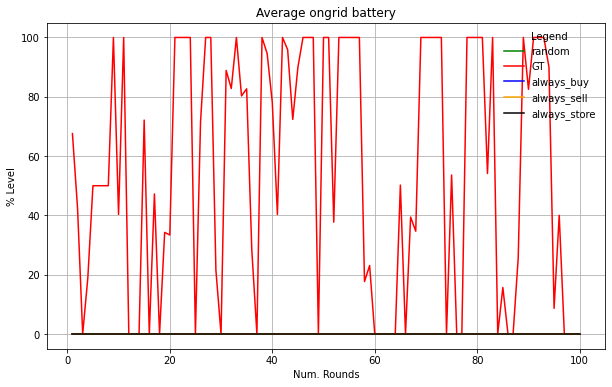

In [ ]:
smart_grid.plot.ongrid_avg_battery()

##### GRAPH 2: average ongrid wallet for each strategy

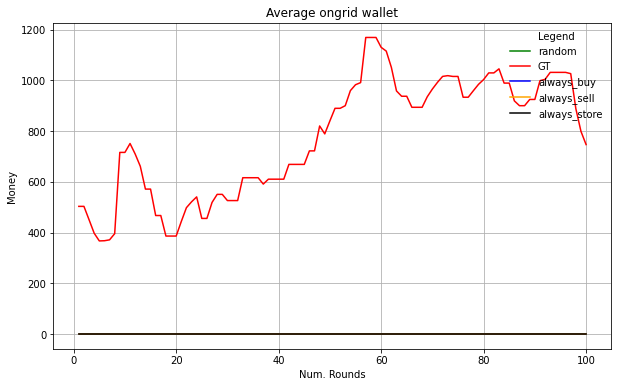

In [ ]:
smart_grid.plot.ongrid_avg_wallet()

##### GRAPH 3: Smart Grid energy supply/demand for each type of player connection (ongrid or offgrid)

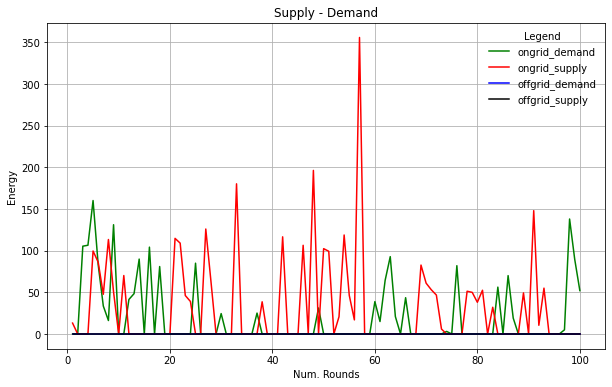

In [ ]:
smart_grid.plot.supply_demand()

### 2.1.2 - Simulation with 1 player ongrid and 1 offgrid, both with GT strategy

#### Smart Grid settings for the simulation

In [ ]:
# Create the smart grid
smart_grid = SmartGrid(rule=RULES[0])

# Add players
add_players_to_smartgrid(smart_grid, 1, 'ongrid', STRATEGIES[1])
add_players_to_smartgrid(smart_grid, 1, 'offgrid', STRATEGIES[1])

Added 1 ongrid players with strategy of type GT.
Added 1 offgrid players with strategy of type GT.


#### Simulation

In [ ]:
# Play the game
play_game(smart_grid, T, verbose=True)

ROUND N.1
START OF THE ROUND
	Players in game: 2 = ongrid[1] + offgrid[1]
	Energy supply: 290.31 = ongrid[ 13.06] + offgrid[277.25]
	Number of suppliers: 2 = ongrid[1] + offgrid[1]
	Energy Demand:   0.00 = ongrid[  0.00] + offgrid[  0.00]
	Number of demanders: 0 = ongrid[0] + offgrid[0]

END OF THE ROUND
	Players in game: 2 = ongrid[1] + offgrid[1]
	Left Energy supply: 290.31 = ongrid[ 13.06] + offgrid[277.25]
	Remaning Number of suppliers: 2 = ongrid[1] + offgrid[1]
	Left Energy Demand:   0.00 = ongrid[  0.00] + offgrid[  0.00]
	Remaning Number of demanders: 0 = ongrid[0] + offgrid[0]
	Number of excluded players in this round: 0
	Number of excluded player until now: 0

------------------

ROUND N.33
START OF THE ROUND
	Players in game: 1 = ongrid[1] + offgrid[0]
	Energy supply: 113.45 = ongrid[113.45] + offgrid[  0.00]
	Number of suppliers: 1 = ongrid[1] + offgrid[0]
	Energy Demand:   0.00 = ongrid[  0.00] + offgrid[  0.00]
	Number of demanders: 0 = ongrid[0] + offgrid[0]

END OF THE 

#### Results

##### GRAPH 1 : average ongrid battery for each strategy

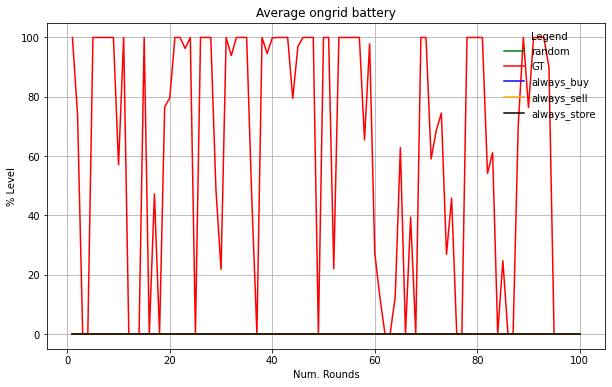

In [ ]:
smart_grid.plot.ongrid_avg_battery()

##### GRAPH 2: average offgrid battery for each strategy

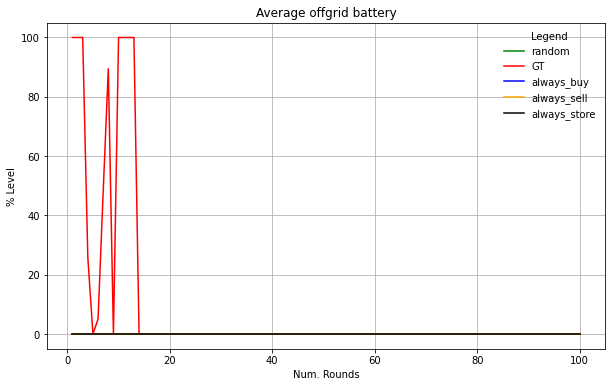

In [ ]:
smart_grid.plot.offgrid_avg_battery()

##### GRAPH 3: average ongrid wallet for each strategy

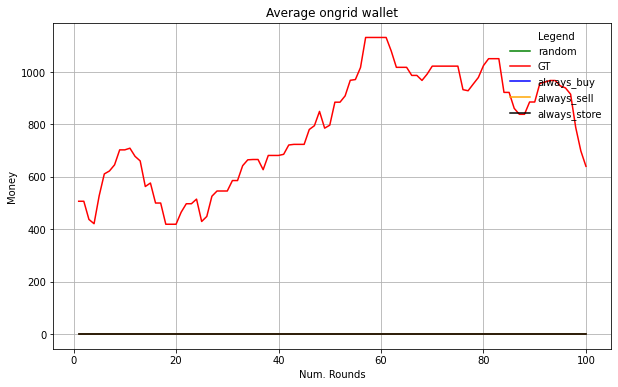

In [ ]:
smart_grid.plot.ongrid_avg_wallet()

##### GRAPH 4: average offgrid wallet for each strategy

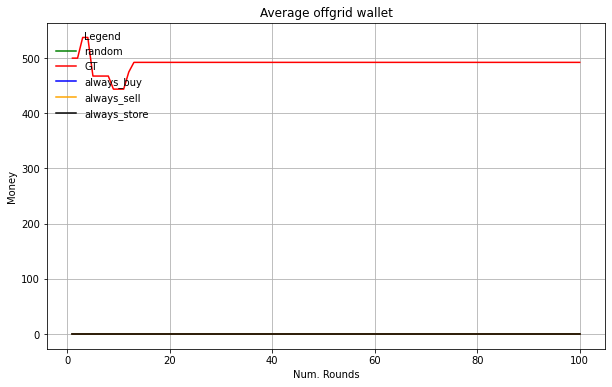

In [ ]:
smart_grid.plot.offgrid_avg_wallet()

##### GRAPH 5: Smart Grid energy supply/demand for each type of player connection (ongrid or offgrid)

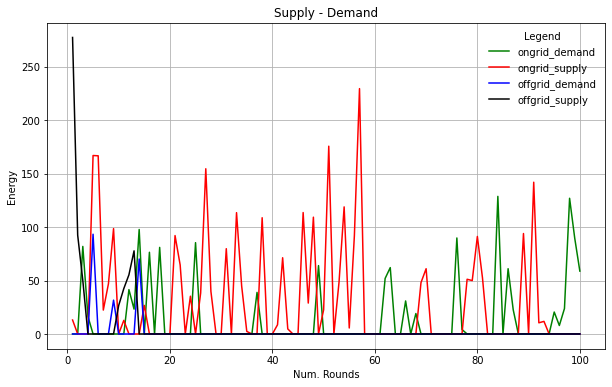

In [ ]:
smart_grid.plot.supply_demand()

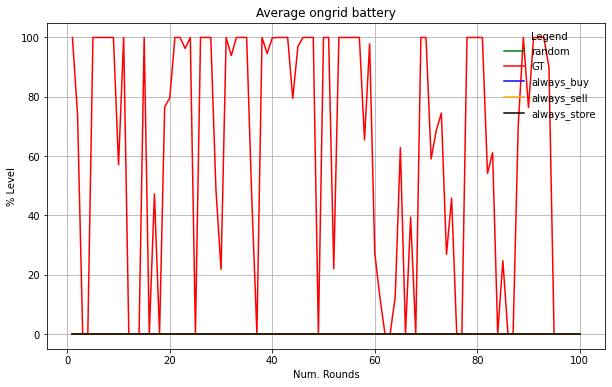

In [ ]:
smart_grid.plot.ongrid_avg_battery()

### 2.1.3 - Simulation with 5 players ongrid, one for each strategy





#### Smart Grid settings for the simulation

In [ ]:
# Create the smart grid
smart_grid = SmartGrid(rule=RULES[0])

# Add the players
for strategy in STRATEGIES:
  add_players_to_smartgrid(smart_grid, 1, 'ongrid', strategy)

Added 1 ongrid players with strategy of type random.
Added 1 ongrid players with strategy of type GT.
Added 1 ongrid players with strategy of type always_buy.
Added 1 ongrid players with strategy of type always_sell.
Added 1 ongrid players with strategy of type always_store.


#### Simulation

In [ ]:
# Play the game
play_game(smart_grid, T, verbose=True)

ROUND N.1
START OF THE ROUND
	Players in game: 5 = ongrid[5] + offgrid[0]
	Energy supply:   0.00 = ongrid[  0.00] + offgrid[  0.00]
	Number of suppliers: 0 = ongrid[0] + offgrid[0]
	Energy Demand: 164.81 = ongrid[164.81] + offgrid[  0.00]
	Number of demanders: 1 = ongrid[1] + offgrid[0]

END OF THE ROUND
	Players in game: 5 = ongrid[5] + offgrid[0]
	Left Energy supply:   0.00 = ongrid[  0.00] + offgrid[  0.00]
	Remaning Number of suppliers: 0 = ongrid[0] + offgrid[0]
	Left Energy Demand: 164.81 = ongrid[164.81] + offgrid[  0.00]
	Remaning Number of demanders: 1 = ongrid[1] + offgrid[0]
	Number of excluded players in this round: 0
	Number of excluded player until now: 0

------------------

ROUND N.33
START OF THE ROUND
	Players in game: 4 = ongrid[4] + offgrid[0]
	Energy supply:  70.55 = ongrid[ 70.55] + offgrid[  0.00]
	Number of suppliers: 1 = ongrid[1] + offgrid[0]
	Energy Demand: 177.22 = ongrid[177.22] + offgrid[  0.00]
	Number of demanders: 2 = ongrid[2] + offgrid[0]

END OF THE 

#### Results

##### GRAPH 1 : average ongrid battery for each strategy

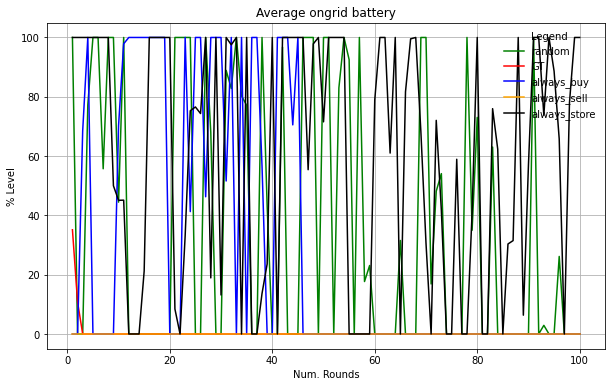

In [ ]:
smart_grid.plot.ongrid_avg_battery()

##### GRAPH 2: average ongrid wallet for each strategy

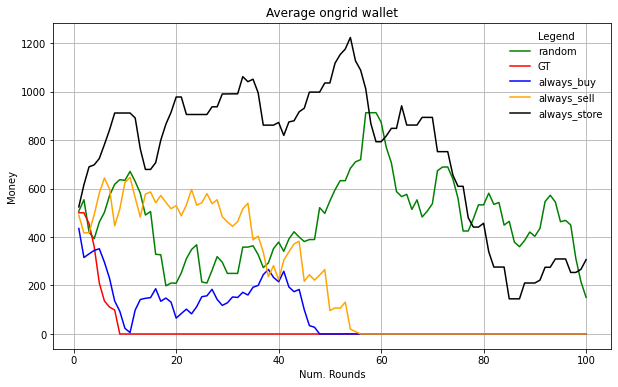

In [ ]:
smart_grid.plot.ongrid_avg_wallet()

##### GRAPH 3: Smart Grid energy supply/demand for each type of player connection (ongrid or offgrid)

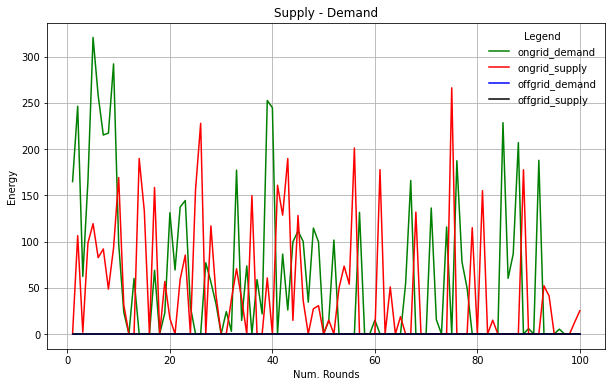

In [ ]:
smart_grid.plot.supply_demand()

### 2.1.4 - Simulation with 5 players ongrid and 5 players offgrid, one for each strategy




#### Smart Grid settings for the simulation

In [ ]:
# Create the smart grid
smart_grid = SmartGrid(rule=RULES[0])

# Add the players
for strategy in STRATEGIES:
  add_players_to_smartgrid(smart_grid, 1, 'ongrid', strategy)
  add_players_to_smartgrid(smart_grid, 1, 'offgrid', strategy)

Added 1 ongrid players with strategy of type random.
Added 1 offgrid players with strategy of type random.
Added 1 ongrid players with strategy of type GT.
Added 1 offgrid players with strategy of type GT.
Added 1 ongrid players with strategy of type always_buy.
Added 1 offgrid players with strategy of type always_buy.
Added 1 ongrid players with strategy of type always_sell.
Added 1 offgrid players with strategy of type always_sell.
Added 1 ongrid players with strategy of type always_store.
Added 1 offgrid players with strategy of type always_store.


#### Simulation

In [ ]:
# Play the game
play_game(smart_grid, T, verbose=True)

ROUND N.1
START OF THE ROUND
	Players in game: 10 = ongrid[5] + offgrid[5]
	Energy supply: 107.02 = ongrid[ 97.62] + offgrid[  9.40]
	Number of suppliers: 2 = ongrid[1] + offgrid[1]
	Energy Demand:  80.68 = ongrid[ 77.87] + offgrid[  2.81]
	Number of demanders: 2 = ongrid[1] + offgrid[1]

END OF THE ROUND
	Players in game: 9 = ongrid[5] + offgrid[4]
	Left Energy supply:  26.35 = ongrid[ 26.35] + offgrid[  0.00]
	Remaning Number of suppliers: 2 = ongrid[1] + offgrid[1]
	Left Energy Demand:   0.00 = ongrid[  0.00] + offgrid[  0.00]
	Remaning Number of demanders: 2 = ongrid[1] + offgrid[1]
	Number of excluded players in this round: 1
	Number of excluded player until now: 1

------------------

ROUND N.33
START OF THE ROUND
	Players in game: 4 = ongrid[4] + offgrid[0]
	Energy supply:   0.00 = ongrid[  0.00] + offgrid[  0.00]
	Number of suppliers: 0 = ongrid[0] + offgrid[0]
	Energy Demand: 164.80 = ongrid[164.80] + offgrid[  0.00]
	Number of demanders: 2 = ongrid[2] + offgrid[0]

END OF THE

#### Results

##### GRAPH 1 : average ongrid battery for each strategy

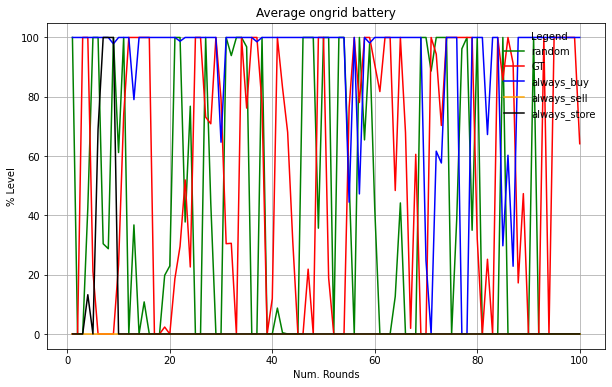

In [ ]:
smart_grid.plot.ongrid_avg_battery()

##### GRAPH 2: average offgrid battery for each strategy

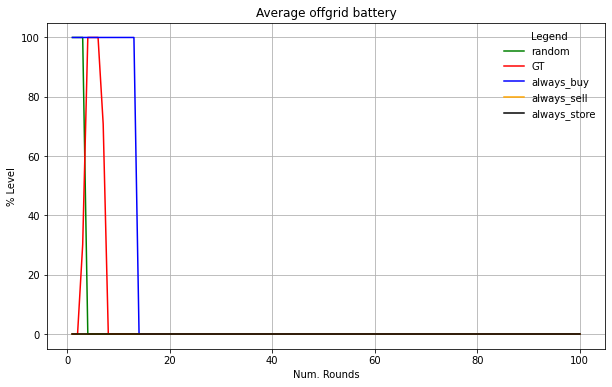

In [ ]:
smart_grid.plot.offgrid_avg_battery()

##### GRAPH 3: average ongrid wallet for each strategy

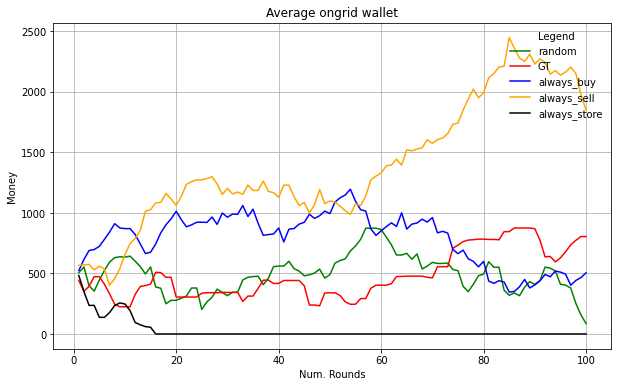

In [ ]:
smart_grid.plot.ongrid_avg_wallet()

##### GRAPH 4: average offgrid wallet for each strategy

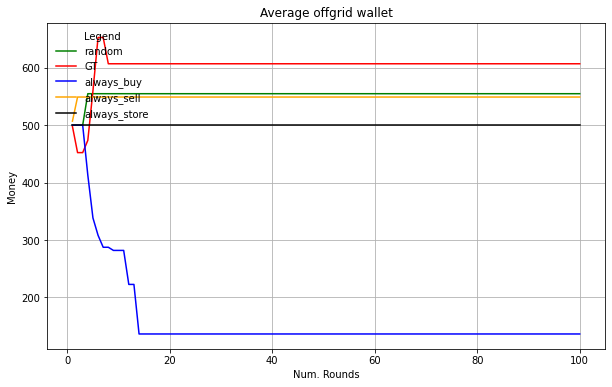

In [ ]:
smart_grid.plot.offgrid_avg_wallet()

##### GRAPH 5: Smart Grid energy supply/demand for each type of player connection (ongrid or offgrid)

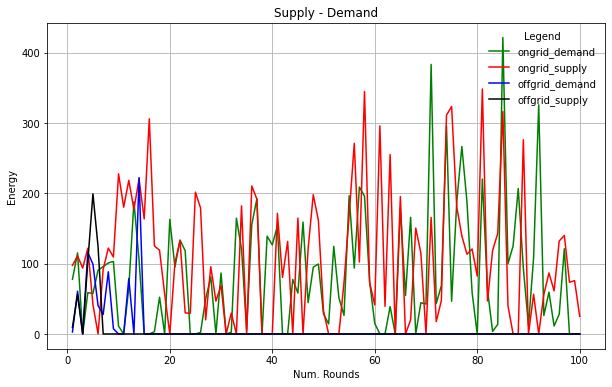

In [ ]:
smart_grid.plot.supply_demand()

### 2.1.5 - Simulations with N players ongrid, both with GT strategy

#### Smart Grid settings for the simulation

In [ ]:
# Create the smart grid
smart_grid = SmartGrid(rule=RULES[0])

# Add players
add_players_to_smartgrid(smart_grid, N, 'ongrid', STRATEGIES[1])

Added 1000 ongrid players with strategy of type GT.


#### Simulation

In [ ]:
# Play the game
play_game(smart_grid, T, verbose=True)

ROUND N.1
START OF THE ROUND
	Players in game: 1000 = ongrid[1000] + offgrid[0]
	Energy supply: 14500.31 = ongrid[14500.31] + offgrid[  0.00]
	Number of suppliers: 221 = ongrid[221] + offgrid[0]
	Energy Demand: 23953.59 = ongrid[23953.59] + offgrid[  0.00]
	Number of demanders: 377 = ongrid[377] + offgrid[0]

END OF THE ROUND
	Players in game: 1000 = ongrid[1000] + offgrid[0]
	Left Energy supply:  -0.00 = ongrid[ -0.00] + offgrid[  0.00]
	Remaning Number of suppliers: 221 = ongrid[221] + offgrid[0]
	Left Energy Demand: 9453.28 = ongrid[9453.28] + offgrid[  0.00]
	Remaning Number of demanders: 377 = ongrid[377] + offgrid[0]
	Number of excluded players in this round: 0
	Number of excluded player until now: 0

------------------

ROUND N.33
START OF THE ROUND
	Players in game: 629 = ongrid[629] + offgrid[0]
	Energy supply: 17717.25 = ongrid[17717.25] + offgrid[  0.00]
	Number of suppliers: 244 = ongrid[244] + offgrid[0]
	Energy Demand: 9003.73 = ongrid[9003.73] + offgrid[  0.00]
	Number o

#### Results

##### GRAPH 1 : average ongrid battery for each strategy

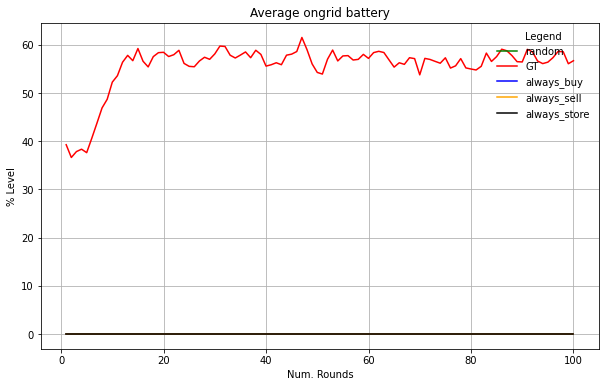

In [ ]:
smart_grid.plot.ongrid_avg_battery()

##### GRAPH 2: average ongrid wallet for each strategy

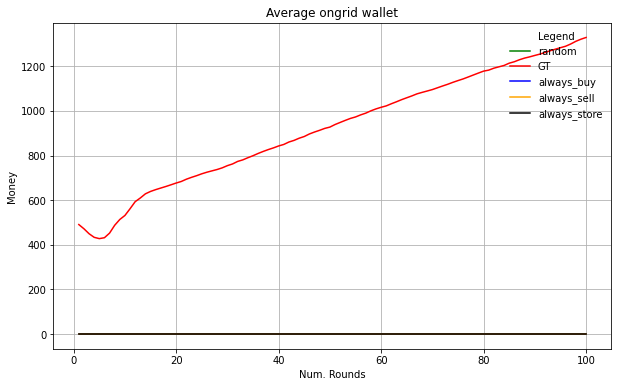

In [ ]:
smart_grid.plot.ongrid_avg_wallet()

##### GRAPH 3: Smart Grid energy supply/demand for each type of player connection (ongrid or offgrid)

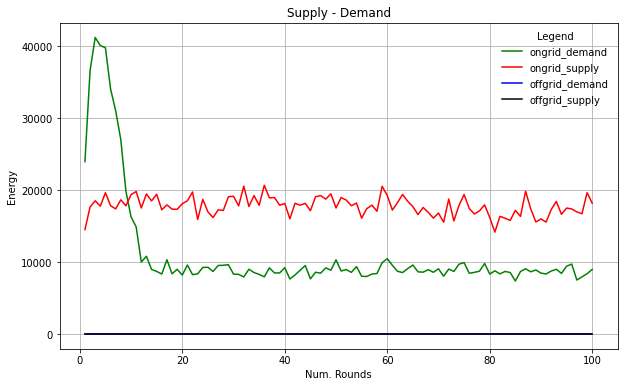

In [ ]:
smart_grid.plot.supply_demand()

### 2.1.6 - Simulation with N/2 player ongrid and N/2 offgrid, both with GT strategy

#### Smart Grid settings for the simulation

In [ ]:
# Create the smart grid
smart_grid = SmartGrid(rule=RULES[0])

# Add players
add_players_to_smartgrid(smart_grid, N/2, 'ongrid', STRATEGIES[1])
add_players_to_smartgrid(smart_grid, N/2, 'offgrid', STRATEGIES[1])

Added 500 ongrid players with strategy of type GT.
Added 500 offgrid players with strategy of type GT.


#### Simulation

In [ ]:
# Play the game
play_game(smart_grid, T, verbose=True)

ROUND N.1
START OF THE ROUND
	Players in game: 1000 = ongrid[500] + offgrid[500]
	Energy supply: 25550.00 = ongrid[7100.80] + offgrid[18449.20]
	Number of suppliers: 294 = ongrid[103] + offgrid[191]
	Energy Demand: 18203.14 = ongrid[12618.03] + offgrid[5585.11]
	Number of demanders: 294 = ongrid[192] + offgrid[102]

END OF THE ROUND
	Players in game: 995 = ongrid[500] + offgrid[495]
	Left Energy supply: 7346.86 = ongrid[1106.96] + offgrid[6239.90]
	Remaning Number of suppliers: 294 = ongrid[103] + offgrid[191]
	Left Energy Demand:   0.00 = ongrid[  0.00] + offgrid[  0.00]
	Remaning Number of demanders: 294 = ongrid[192] + offgrid[102]
	Number of excluded players in this round: 5
	Number of excluded player until now: 5

------------------

ROUND N.33
START OF THE ROUND
	Players in game: 612 = ongrid[315] + offgrid[297]
	Energy supply: 23999.19 = ongrid[9817.86] + offgrid[14181.33]
	Number of suppliers: 259 = ongrid[123] + offgrid[136]
	Energy Demand: 7426.34 = ongrid[3846.63] + offgrid[

#### Results

##### GRAPH 1 : average ongrid battery for each strategy

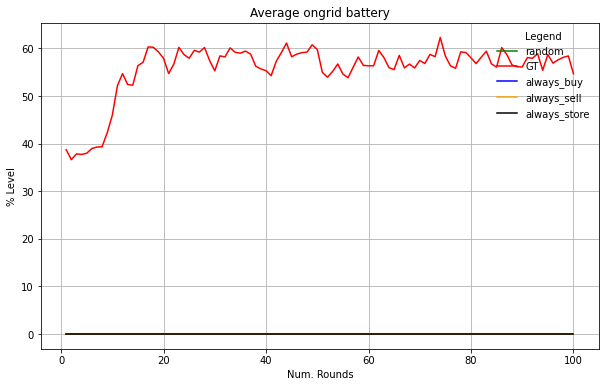

In [ ]:
smart_grid.plot.ongrid_avg_battery()

##### GRAPH 2: average offgrid battery for each strategy

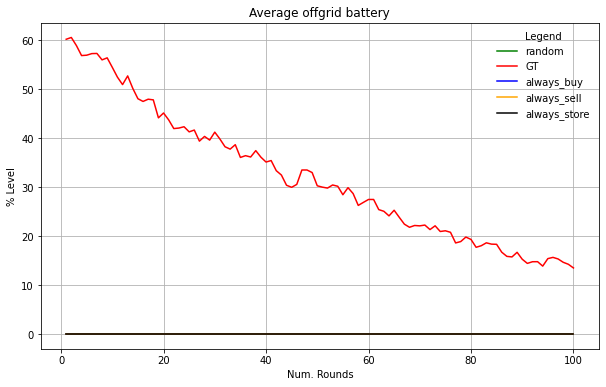

In [ ]:
smart_grid.plot.offgrid_avg_battery()

##### GRAPH 3: average ongrid wallet for each strategy

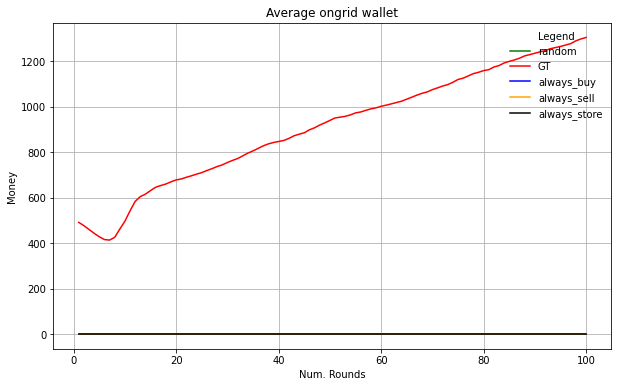

In [ ]:
smart_grid.plot.ongrid_avg_wallet()

##### GRAPH 4: average offgrid wallet for each strategy

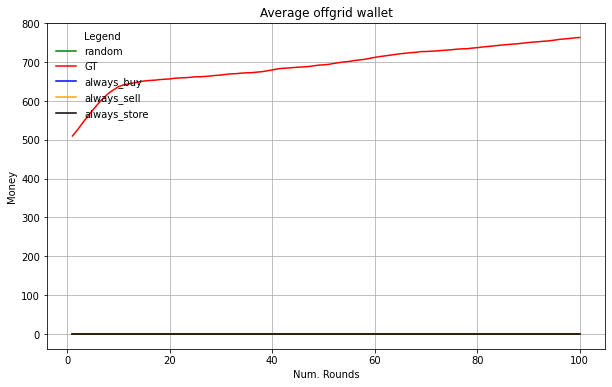

In [ ]:
smart_grid.plot.offgrid_avg_wallet()

##### GRAPH 5: Smart Grid energy supply/demand for each type of player connection (ongrid or offgrid)

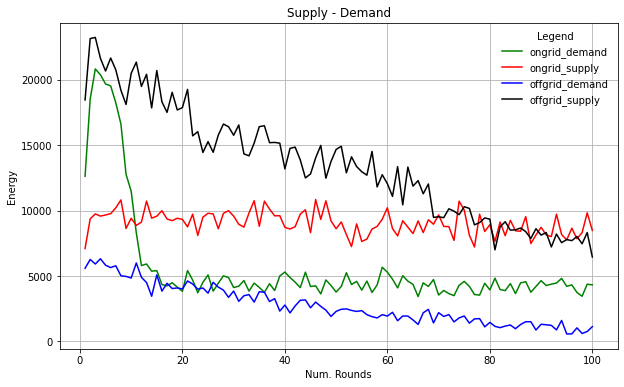

In [ ]:
smart_grid.plot.supply_demand()

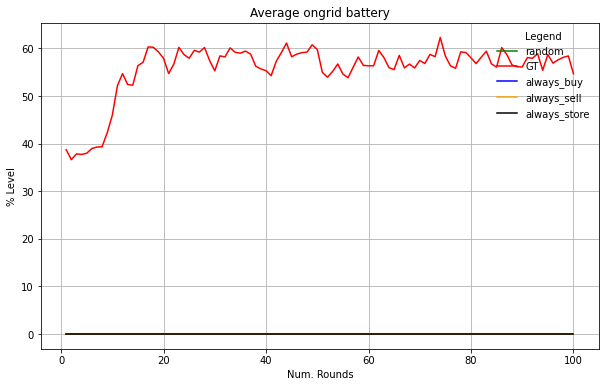

In [ ]:
smart_grid.plot.ongrid_avg_battery()

### 2.1.7 - Simulation with N/5 players ongrid, one for each strategy





#### Smart Grid settings for the simulation

In [ ]:
# Create the smart grid
smart_grid = SmartGrid(rule=RULES[0])

# Add the players
for strategy in STRATEGIES:
  add_players_to_smartgrid(smart_grid, N/5, 'ongrid', strategy)

Added 200 ongrid players with strategy of type random.
Added 200 ongrid players with strategy of type GT.
Added 200 ongrid players with strategy of type always_buy.
Added 200 ongrid players with strategy of type always_sell.
Added 200 ongrid players with strategy of type always_store.


#### Simulation

In [ ]:
# Play the game
play_game(smart_grid, T, verbose=True)

ROUND N.1
START OF THE ROUND
	Players in game: 1000 = ongrid[1000] + offgrid[0]
	Energy supply: 17763.07 = ongrid[17763.07] + offgrid[  0.00]
	Number of suppliers: 234 = ongrid[234] + offgrid[0]
	Energy Demand: 28076.65 = ongrid[28076.65] + offgrid[  0.00]
	Number of demanders: 299 = ongrid[299] + offgrid[0]

END OF THE ROUND
	Players in game: 1000 = ongrid[1000] + offgrid[0]
	Left Energy supply:   0.00 = ongrid[  0.00] + offgrid[  0.00]
	Remaning Number of suppliers: 234 = ongrid[234] + offgrid[0]
	Left Energy Demand: 10313.57 = ongrid[10313.57] + offgrid[  0.00]
	Remaning Number of demanders: 299 = ongrid[299] + offgrid[0]
	Number of excluded players in this round: 0
	Number of excluded player until now: 0

------------------

ROUND N.33
START OF THE ROUND
	Players in game: 596 = ongrid[596] + offgrid[0]
	Energy supply: 10961.68 = ongrid[10961.68] + offgrid[  0.00]
	Number of suppliers: 152 = ongrid[152] + offgrid[0]
	Energy Demand: 7634.51 = ongrid[7634.51] + offgrid[  0.00]
	Number

#### Results

##### GRAPH 1 : average ongrid battery for each strategy

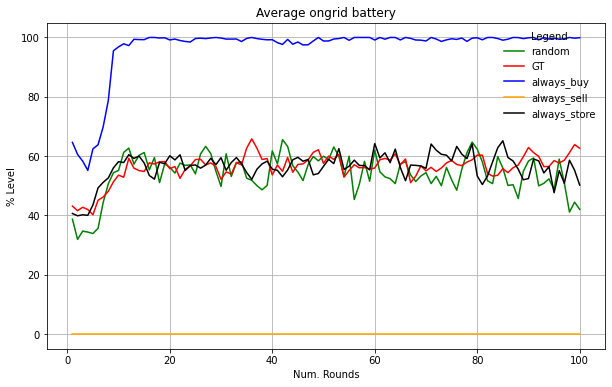

In [ ]:
smart_grid.plot.ongrid_avg_battery()

##### GRAPH 2: average ongrid wallet for each strategy

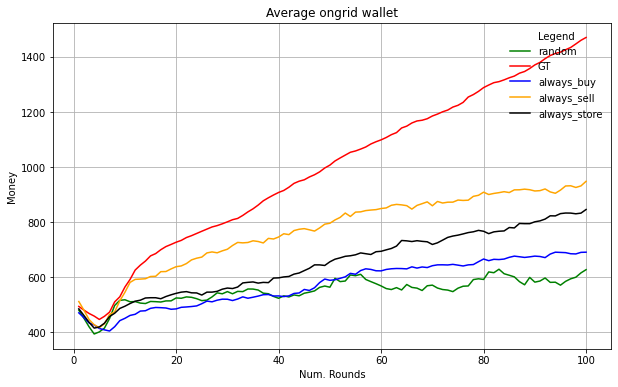

In [ ]:
smart_grid.plot.ongrid_avg_wallet()

##### GRAPH 3: Smart Grid energy supply/demand for each type of player connection (ongrid or offgrid)

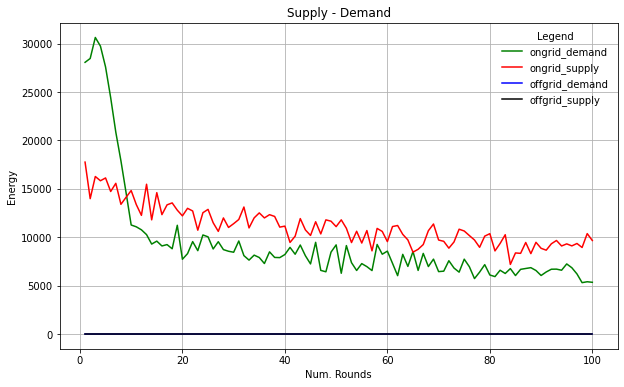

In [ ]:
smart_grid.plot.supply_demand()

### 2.1.8 - Simulation with N/10 players ongrid and N/10 players offgrid, one group for each strategy




#### Smart Grid settings for the simulation

In [ ]:
# Create the smart grid
smart_grid = SmartGrid(rule=RULES[0])

# Add the players
for strategy in STRATEGIES:
  add_players_to_smartgrid(smart_grid, N/10, 'ongrid', strategy)
  add_players_to_smartgrid(smart_grid, N/10, 'offgrid', strategy)

Added 100 ongrid players with strategy of type random.
Added 100 offgrid players with strategy of type random.
Added 100 ongrid players with strategy of type GT.
Added 100 offgrid players with strategy of type GT.
Added 100 ongrid players with strategy of type always_buy.
Added 100 offgrid players with strategy of type always_buy.
Added 100 ongrid players with strategy of type always_sell.
Added 100 offgrid players with strategy of type always_sell.
Added 100 ongrid players with strategy of type always_store.
Added 100 offgrid players with strategy of type always_store.


#### Simulation

In [ ]:
# Play the game
play_game(smart_grid, T, verbose=True)

ROUND N.1
START OF THE ROUND
	Players in game: 1000 = ongrid[500] + offgrid[500]
	Energy supply: 26046.23 = ongrid[8845.76] + offgrid[17200.48]
	Number of suppliers: 271 = ongrid[111] + offgrid[160]
	Energy Demand: 24628.65 = ongrid[14259.92] + offgrid[10368.73]
	Number of demanders: 267 = ongrid[144] + offgrid[123]

END OF THE ROUND
	Players in game: 925 = ongrid[500] + offgrid[425]
	Left Energy supply: 1417.58 = ongrid[ 21.70] + offgrid[1395.88]
	Remaning Number of suppliers: 271 = ongrid[111] + offgrid[160]
	Left Energy Demand:  -0.00 = ongrid[ -0.00] + offgrid[  0.00]
	Remaning Number of demanders: 267 = ongrid[144] + offgrid[123]
	Number of excluded players in this round: 75
	Number of excluded player until now: 75

------------------

ROUND N.33
START OF THE ROUND
	Players in game: 391 = ongrid[300] + offgrid[91]
	Energy supply: 9367.98 = ongrid[5445.62] + offgrid[3922.36]
	Number of suppliers: 105 = ongrid[71] + offgrid[34]
	Energy Demand: 4456.11 = ongrid[3665.87] + offgrid[790

#### Results

##### GRAPH 1 : average ongrid battery for each strategy

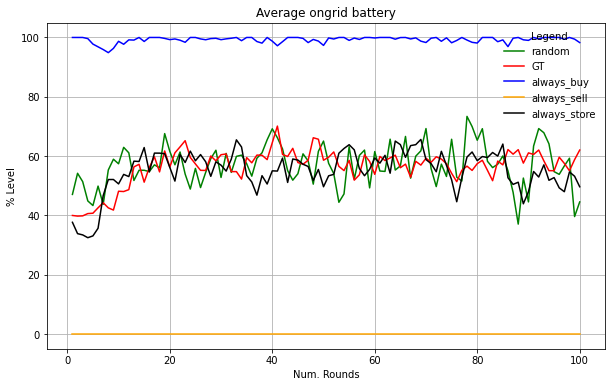

In [ ]:
smart_grid.plot.ongrid_avg_battery()

##### GRAPH 2: average offgrid battery for each strategy

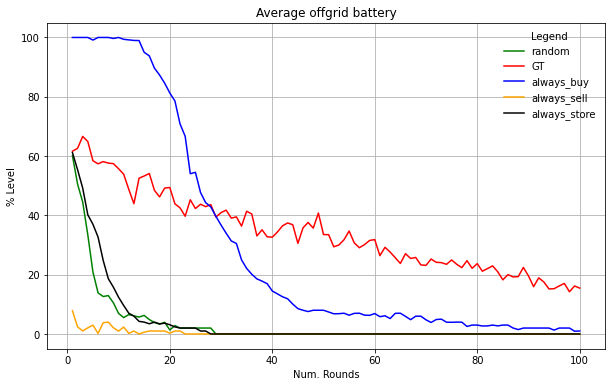

In [ ]:
smart_grid.plot.offgrid_avg_battery()

##### GRAPH 3: average ongrid wallet for each strategy

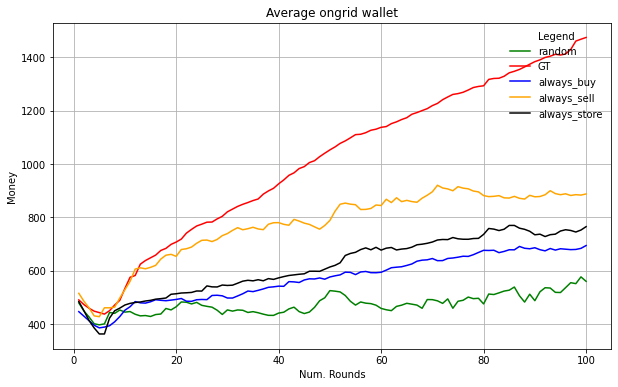

In [ ]:
smart_grid.plot.ongrid_avg_wallet()

##### GRAPH 4: average offgrid wallet for each strategy

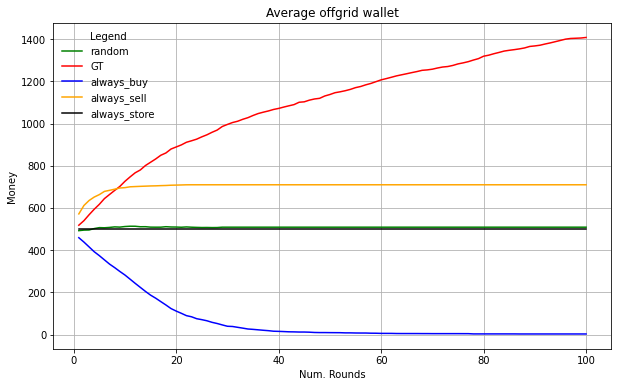

In [ ]:
smart_grid.plot.offgrid_avg_wallet()

##### GRAPH 5: Smart Grid energy supply/demand for each type of player connection (ongrid or offgrid)

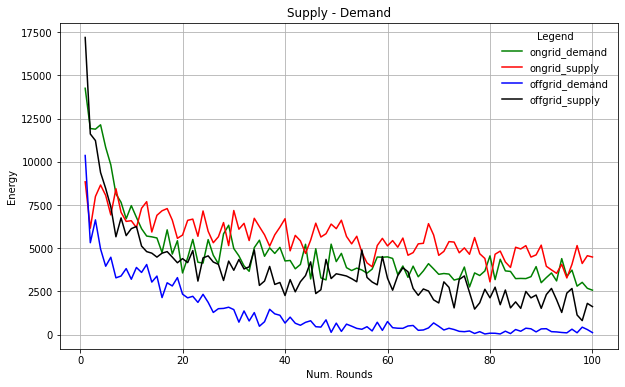

In [ ]:
smart_grid.plot.supply_demand()

## 2.2 - SMART GRID WITH ENERGY PRIORITY QUEUE RULE

### 2.2.1 - Simulations with 2 players ongrid, both with GT strategy

#### Smart Grid settings for the simulation

In [ ]:
# Create the smart grid
smart_grid = SmartGrid(rule=RULES[1])

# Add players
add_players_to_smartgrid(smart_grid, 2, 'ongrid', STRATEGIES[1])

Added 2 ongrid players with strategy of type GT.


#### Simulation

In [ ]:
# Play the game
play_game(smart_grid, T, verbose=True)

ROUND N.1
START OF THE ROUND
	Players in game: 2 = ongrid[2] + offgrid[0]
	Energy supply:  13.06 = ongrid[ 13.06] + offgrid[  0.00]
	Number of suppliers: 1 = ongrid[1] + offgrid[0]
	Energy Demand:   0.00 = ongrid[  0.00] + offgrid[  0.00]
	Number of demanders: 0 = ongrid[0] + offgrid[0]

END OF THE ROUND
	Players in game: 2 = ongrid[2] + offgrid[0]
	Left Energy supply:  13.06 = ongrid[ 13.06] + offgrid[  0.00]
	Remaning Number of suppliers: 1 = ongrid[1] + offgrid[0]
	Left Energy Demand:   0.00 = ongrid[  0.00] + offgrid[  0.00]
	Remaning Number of demanders: 0 = ongrid[0] + offgrid[0]
	Number of excluded players in this round: 0
	Number of excluded player until now: 0

------------------

ROUND N.33
START OF THE ROUND
	Players in game: 1 = ongrid[1] + offgrid[0]
	Energy supply: 113.45 = ongrid[113.45] + offgrid[  0.00]
	Number of suppliers: 1 = ongrid[1] + offgrid[0]
	Energy Demand:   0.00 = ongrid[  0.00] + offgrid[  0.00]
	Number of demanders: 0 = ongrid[0] + offgrid[0]

END OF THE 

#### Results

##### GRAPH 1 : average ongrid battery for each strategy

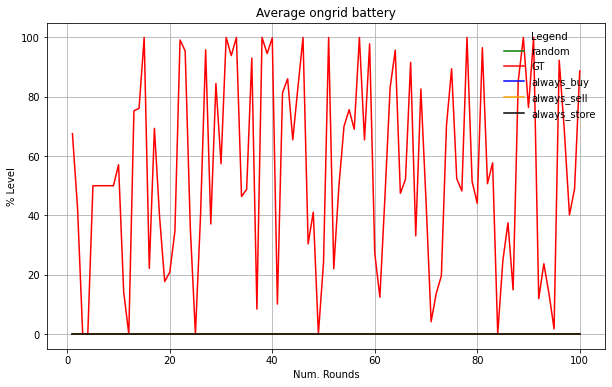

In [ ]:
smart_grid.plot.ongrid_avg_battery()

##### GRAPH 2: average ongrid wallet for each strategy

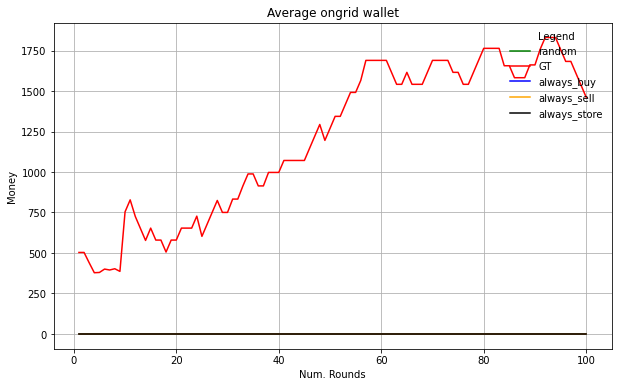

In [ ]:
smart_grid.plot.ongrid_avg_wallet()

##### GRAPH 3: Smart Grid energy supply/demand for each type of player connection (ongrid or offgrid)

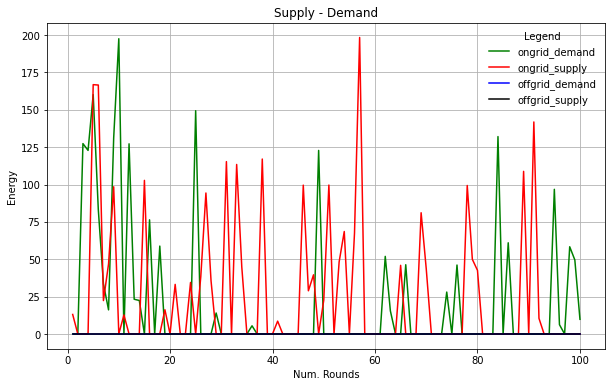

In [ ]:
smart_grid.plot.supply_demand()

### 2.2.2 - Simulation with 1 player ongrid and 1 offgrid, both with GT strategy

#### Smart Grid settings for the simulation

In [ ]:
# Create the smart grid
smart_grid = SmartGrid(rule=RULES[1])

# Add players
add_players_to_smartgrid(smart_grid, 1, 'ongrid', STRATEGIES[1])
add_players_to_smartgrid(smart_grid, 1, 'offgrid', STRATEGIES[1])

Added 1 ongrid players with strategy of type GT.
Added 1 offgrid players with strategy of type GT.


#### Simulation

In [ ]:
# Play the game
play_game(smart_grid, T, verbose=True)

ROUND N.1
START OF THE ROUND
	Players in game: 2 = ongrid[1] + offgrid[1]
	Energy supply: 290.31 = ongrid[ 13.06] + offgrid[277.25]
	Number of suppliers: 2 = ongrid[1] + offgrid[1]
	Energy Demand:   0.00 = ongrid[  0.00] + offgrid[  0.00]
	Number of demanders: 0 = ongrid[0] + offgrid[0]

END OF THE ROUND
	Players in game: 2 = ongrid[1] + offgrid[1]
	Left Energy supply: 290.31 = ongrid[ 13.06] + offgrid[277.25]
	Remaning Number of suppliers: 2 = ongrid[1] + offgrid[1]
	Left Energy Demand:   0.00 = ongrid[  0.00] + offgrid[  0.00]
	Remaning Number of demanders: 0 = ongrid[0] + offgrid[0]
	Number of excluded players in this round: 0
	Number of excluded player until now: 0

------------------

ROUND N.33
START OF THE ROUND
	Players in game: 1 = ongrid[1] + offgrid[0]
	Energy supply: 180.27 = ongrid[180.27] + offgrid[  0.00]
	Number of suppliers: 1 = ongrid[1] + offgrid[0]
	Energy Demand:   0.00 = ongrid[  0.00] + offgrid[  0.00]
	Number of demanders: 0 = ongrid[0] + offgrid[0]

END OF THE 

#### Results

##### GRAPH 1 : average ongrid battery for each strategy

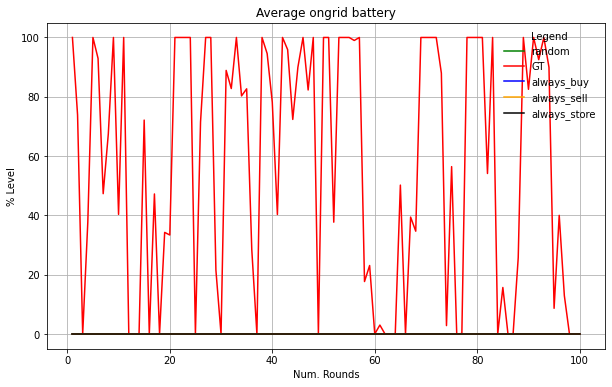

In [ ]:
smart_grid.plot.ongrid_avg_battery()

##### GRAPH 2: average offgrid battery for each strategy

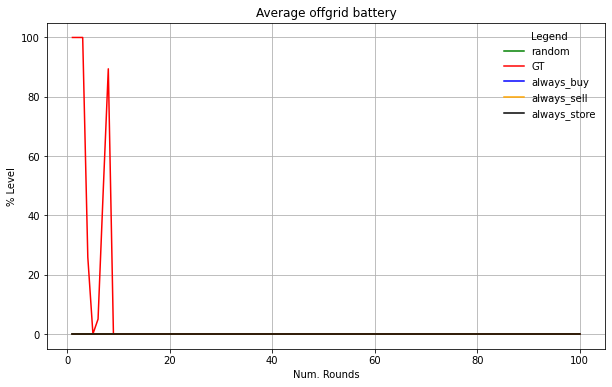

In [ ]:
smart_grid.plot.offgrid_avg_battery()

##### GRAPH 3: average ongrid wallet for each strategy

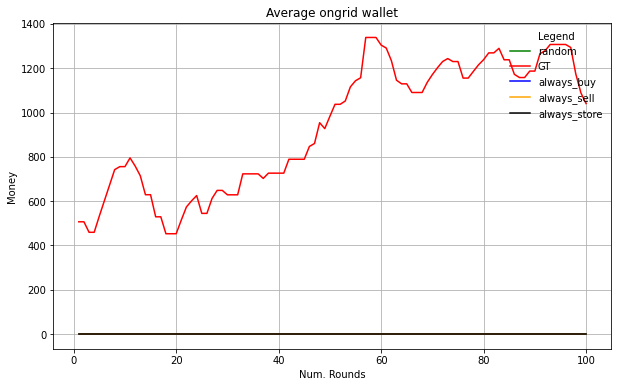

In [ ]:
smart_grid.plot.ongrid_avg_wallet()

##### GRAPH 4: average offgrid wallet for each strategy

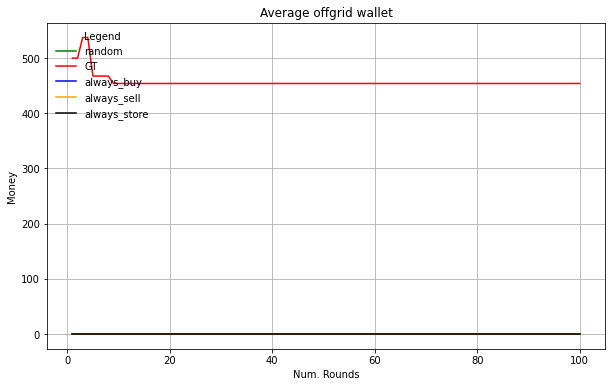

In [ ]:
smart_grid.plot.offgrid_avg_wallet()

##### GRAPH 5: Smart Grid energy supply/demand for each type of player connection (ongrid or offgrid)

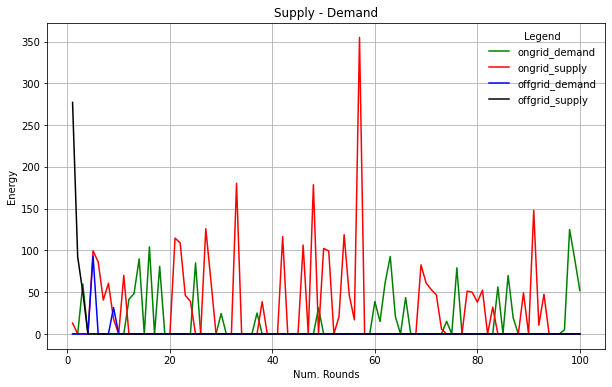

In [ ]:
smart_grid.plot.supply_demand()

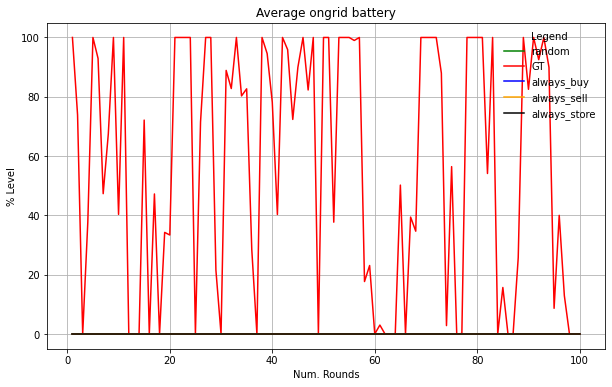

In [ ]:
smart_grid.plot.ongrid_avg_battery()

### 2.2.3 - Simulation with 5 players ongrid, one for each strategy





#### Smart Grid settings for the simulation

In [ ]:
# Create the smart grid
smart_grid = SmartGrid(rule=RULES[1])

# Add the players
for strategy in STRATEGIES:
  add_players_to_smartgrid(smart_grid, 1, 'ongrid', strategy)

Added 1 ongrid players with strategy of type random.
Added 1 ongrid players with strategy of type GT.
Added 1 ongrid players with strategy of type always_buy.
Added 1 ongrid players with strategy of type always_sell.
Added 1 ongrid players with strategy of type always_store.


#### Simulation

In [ ]:
# Play the game
play_game(smart_grid, T, verbose=True)

ROUND N.1
START OF THE ROUND
	Players in game: 5 = ongrid[5] + offgrid[0]
	Energy supply: 163.21 = ongrid[163.21] + offgrid[  0.00]
	Number of suppliers: 1 = ongrid[1] + offgrid[0]
	Energy Demand: 203.98 = ongrid[203.98] + offgrid[  0.00]
	Number of demanders: 1 = ongrid[1] + offgrid[0]

END OF THE ROUND
	Players in game: 5 = ongrid[5] + offgrid[0]
	Left Energy supply:   0.00 = ongrid[  0.00] + offgrid[  0.00]
	Remaning Number of suppliers: 1 = ongrid[1] + offgrid[0]
	Left Energy Demand:  40.77 = ongrid[ 40.77] + offgrid[  0.00]
	Remaning Number of demanders: 1 = ongrid[1] + offgrid[0]
	Number of excluded players in this round: 0
	Number of excluded player until now: 0

------------------

ROUND N.33
START OF THE ROUND
	Players in game: 4 = ongrid[4] + offgrid[0]
	Energy supply: 143.29 = ongrid[143.29] + offgrid[  0.00]
	Number of suppliers: 2 = ongrid[2] + offgrid[0]
	Energy Demand:  89.54 = ongrid[ 89.54] + offgrid[  0.00]
	Number of demanders: 1 = ongrid[1] + offgrid[0]

END OF THE 

#### Results

##### GRAPH 1 : average ongrid battery for each strategy

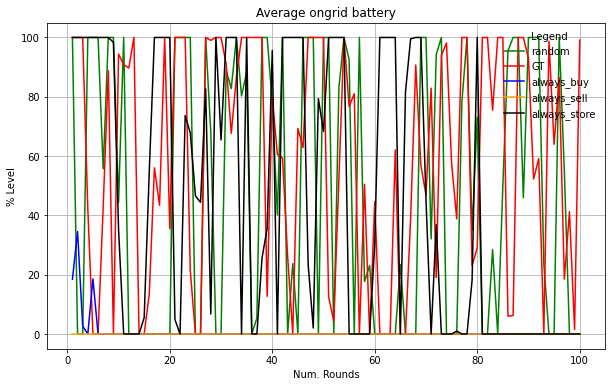

In [ ]:
smart_grid.plot.ongrid_avg_battery()

##### GRAPH 2: average ongrid wallet for each strategy

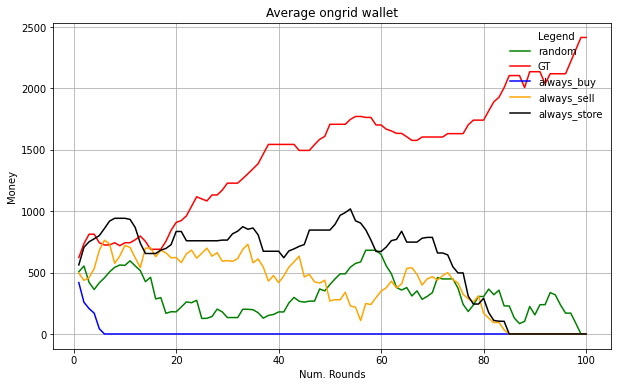

In [ ]:
smart_grid.plot.ongrid_avg_wallet()

##### GRAPH 3: Smart Grid energy supply/demand for each type of player connection (ongrid or offgrid)

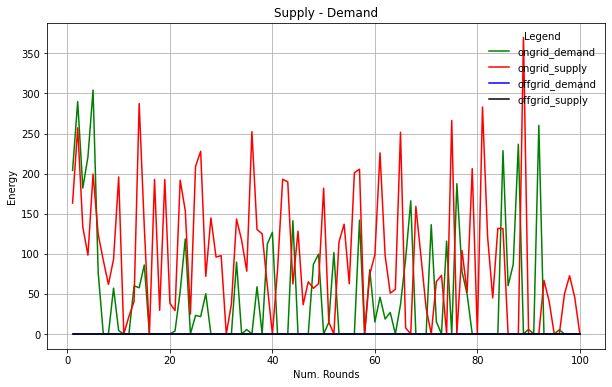

In [ ]:
smart_grid.plot.supply_demand()

### 2.2.4 - Simulation with 5 players ongrid and 5 players offgrid, one for each strategy




#### Smart Grid settings for the simulation

In [ ]:
# Create the smart grid
smart_grid = SmartGrid(rule=RULES[1])

# Add the players
for strategy in STRATEGIES:
  add_players_to_smartgrid(smart_grid, 1, 'ongrid', strategy)
  add_players_to_smartgrid(smart_grid, 1, 'offgrid', strategy)

Added 1 ongrid players with strategy of type random.
Added 1 offgrid players with strategy of type random.
Added 1 ongrid players with strategy of type GT.
Added 1 offgrid players with strategy of type GT.
Added 1 ongrid players with strategy of type always_buy.
Added 1 offgrid players with strategy of type always_buy.
Added 1 ongrid players with strategy of type always_sell.
Added 1 offgrid players with strategy of type always_sell.
Added 1 ongrid players with strategy of type always_store.
Added 1 offgrid players with strategy of type always_store.


#### Simulation

In [ ]:
# Play the game
play_game(smart_grid, T, verbose=True)

ROUND N.1
START OF THE ROUND
	Players in game: 10 = ongrid[5] + offgrid[5]
	Energy supply:  51.65 = ongrid[ 42.25] + offgrid[  9.40]
	Number of suppliers: 2 = ongrid[1] + offgrid[1]
	Energy Demand: 172.99 = ongrid[170.18] + offgrid[  2.81]
	Number of demanders: 3 = ongrid[2] + offgrid[1]

END OF THE ROUND
	Players in game: 8 = ongrid[5] + offgrid[3]
	Left Energy supply:   0.00 = ongrid[  0.00] + offgrid[  0.00]
	Remaning Number of suppliers: 2 = ongrid[1] + offgrid[1]
	Left Energy Demand: 121.34 = ongrid[118.53] + offgrid[  2.81]
	Remaning Number of demanders: 3 = ongrid[2] + offgrid[1]
	Number of excluded players in this round: 2
	Number of excluded player until now: 2

------------------

ROUND N.33
START OF THE ROUND
	Players in game: 2 = ongrid[2] + offgrid[0]
	Energy supply:   0.00 = ongrid[  0.00] + offgrid[  0.00]
	Number of suppliers: 0 = ongrid[0] + offgrid[0]
	Energy Demand:  96.26 = ongrid[ 96.26] + offgrid[  0.00]
	Number of demanders: 2 = ongrid[2] + offgrid[0]

END OF THE

#### Results

##### GRAPH 1 : average ongrid battery for each strategy

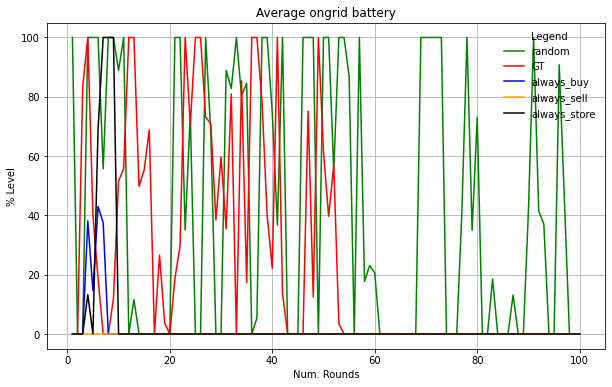

In [ ]:
smart_grid.plot.ongrid_avg_battery()

##### GRAPH 2: average offgrid battery for each strategy

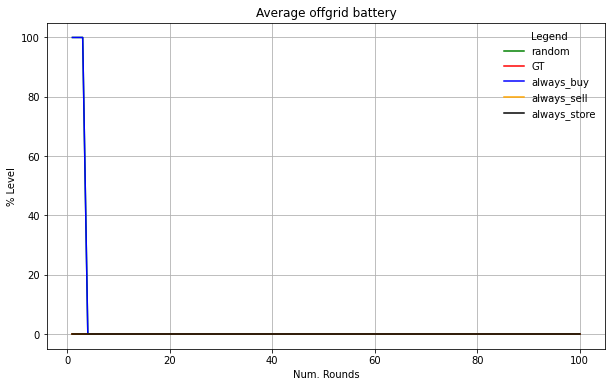

In [ ]:
smart_grid.plot.offgrid_avg_battery()

##### GRAPH 3: average ongrid wallet for each strategy

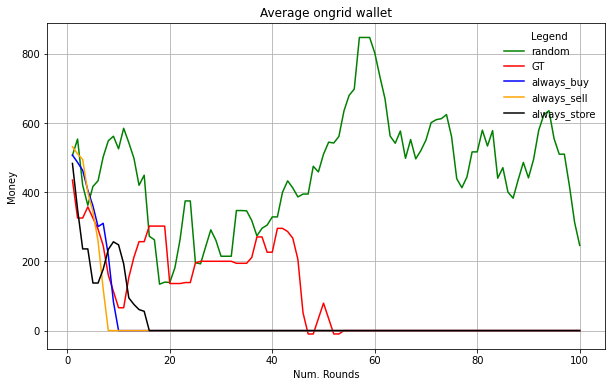

In [ ]:
smart_grid.plot.ongrid_avg_wallet()

##### GRAPH 4: average offgrid wallet for each strategy

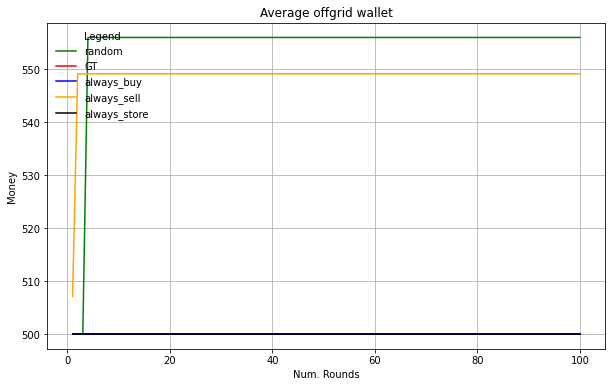

In [ ]:
smart_grid.plot.offgrid_avg_wallet()

##### GRAPH 5: Smart Grid energy supply/demand for each type of player connection (ongrid or offgrid)

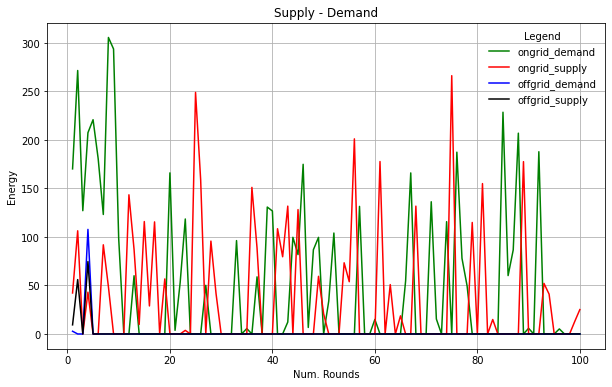

In [ ]:
smart_grid.plot.supply_demand()

### 2.2.5 - Simulations with N players ongrid, both with GT strategy

#### Smart Grid settings for the simulation

In [ ]:
# Create the smart grid
smart_grid = SmartGrid(rule=RULES[1])

# Add players
add_players_to_smartgrid(smart_grid, N, 'ongrid', STRATEGIES[1])

Added 1000 ongrid players with strategy of type GT.


#### Simulation

In [ ]:
# Play the game
play_game(smart_grid, T, verbose=True)

ROUND N.1
START OF THE ROUND
	Players in game: 1000 = ongrid[1000] + offgrid[0]
	Energy supply: 14114.63 = ongrid[14114.63] + offgrid[  0.00]
	Number of suppliers: 218 = ongrid[218] + offgrid[0]
	Energy Demand: 23565.09 = ongrid[23565.09] + offgrid[  0.00]
	Number of demanders: 382 = ongrid[382] + offgrid[0]

END OF THE ROUND
	Players in game: 1000 = ongrid[1000] + offgrid[0]
	Left Energy supply:   0.00 = ongrid[  0.00] + offgrid[  0.00]
	Remaning Number of suppliers: 218 = ongrid[218] + offgrid[0]
	Left Energy Demand: 9450.46 = ongrid[9450.46] + offgrid[  0.00]
	Remaning Number of demanders: 382 = ongrid[382] + offgrid[0]
	Number of excluded players in this round: 0
	Number of excluded player until now: 0

------------------

ROUND N.33
START OF THE ROUND
	Players in game: 633 = ongrid[633] + offgrid[0]
	Energy supply: 16185.68 = ongrid[16185.68] + offgrid[  0.00]
	Number of suppliers: 215 = ongrid[215] + offgrid[0]
	Energy Demand: 10265.83 = ongrid[10265.83] + offgrid[  0.00]
	Number

#### Results

##### GRAPH 1 : average ongrid battery for each strategy

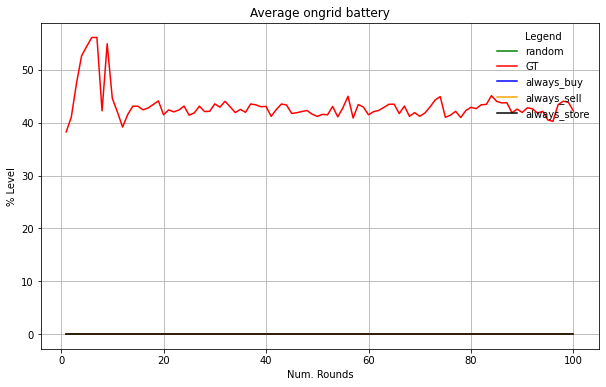

In [ ]:
smart_grid.plot.ongrid_avg_battery()

##### GRAPH 2: average ongrid wallet for each strategy

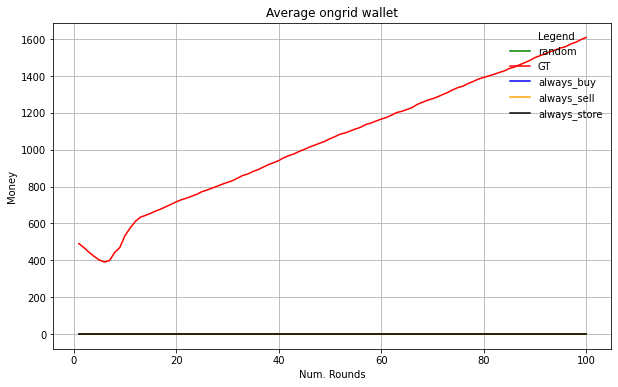

In [ ]:
smart_grid.plot.ongrid_avg_wallet()

##### GRAPH 3: Smart Grid energy supply/demand for each type of player connection (ongrid or offgrid)

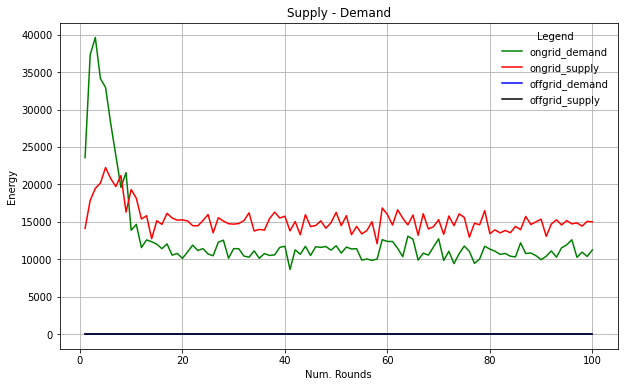

In [ ]:
smart_grid.plot.supply_demand()

### 2.2.6 - Simulation with N/2 player ongrid and N/2 offgrid, both with GT strategy

#### Smart Grid settings for the simulation

In [ ]:
# Create the smart grid
smart_grid = SmartGrid(rule=RULES[1])

# Add players
add_players_to_smartgrid(smart_grid, N/2, 'ongrid', STRATEGIES[1])
add_players_to_smartgrid(smart_grid, N/2, 'offgrid', STRATEGIES[1])

Added 500 ongrid players with strategy of type GT.
Added 500 offgrid players with strategy of type GT.


#### Simulation

In [ ]:
# Play the game
play_game(smart_grid, T, verbose=True)

ROUND N.1
START OF THE ROUND
	Players in game: 1000 = ongrid[500] + offgrid[500]
	Energy supply: 27700.13 = ongrid[8283.26] + offgrid[19416.87]
	Number of suppliers: 310 = ongrid[117] + offgrid[193]
	Energy Demand: 17671.28 = ongrid[12023.63] + offgrid[5647.65]
	Number of demanders: 284 = ongrid[185] + offgrid[99]

END OF THE ROUND
	Players in game: 993 = ongrid[500] + offgrid[493]
	Left Energy supply: 10028.85 = ongrid[3865.81] + offgrid[6163.04]
	Remaning Number of suppliers: 310 = ongrid[117] + offgrid[193]
	Left Energy Demand:   0.00 = ongrid[  0.00] + offgrid[  0.00]
	Remaning Number of demanders: 284 = ongrid[185] + offgrid[99]
	Number of excluded players in this round: 7
	Number of excluded player until now: 7

------------------

ROUND N.33
START OF THE ROUND
	Players in game: 413 = ongrid[329] + offgrid[84]
	Energy supply: 10505.60 = ongrid[7630.80] + offgrid[2874.80]
	Number of suppliers: 144 = ongrid[111] + offgrid[33]
	Energy Demand: 5824.48 = ongrid[4907.12] + offgrid[917.

#### Results

##### GRAPH 1 : average ongrid battery for each strategy

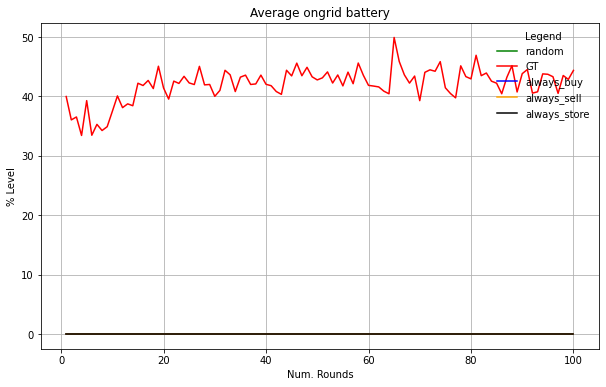

In [ ]:
smart_grid.plot.ongrid_avg_battery()

##### GRAPH 2: average offgrid battery for each strategy

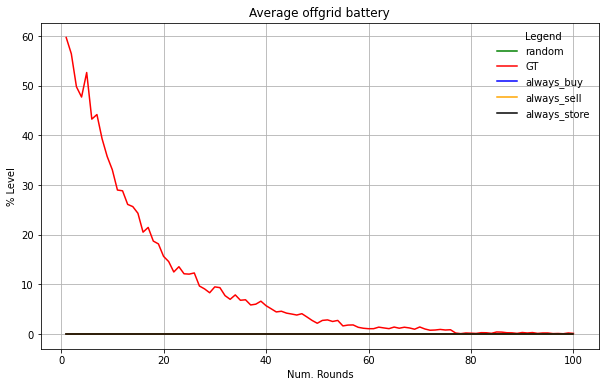

In [ ]:
smart_grid.plot.offgrid_avg_battery()

##### GRAPH 3: average ongrid wallet for each strategy

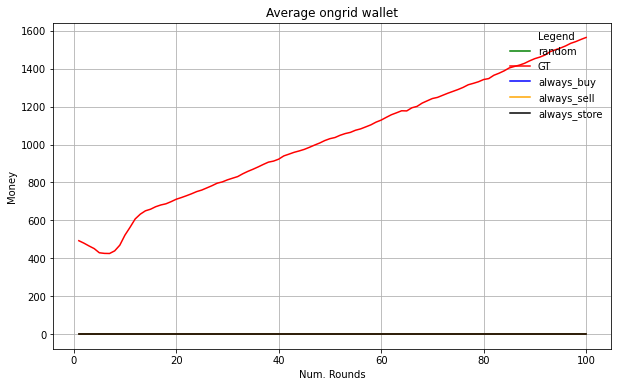

In [ ]:
smart_grid.plot.ongrid_avg_wallet()

##### GRAPH 4: average offgrid wallet for each strategy

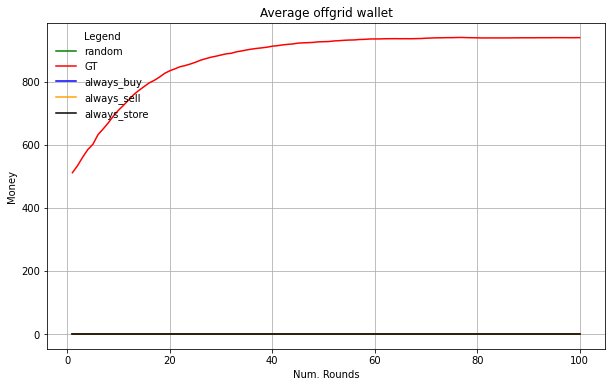

In [ ]:
smart_grid.plot.offgrid_avg_wallet()

##### GRAPH 5: Smart Grid energy supply/demand for each type of player connection (ongrid or offgrid)

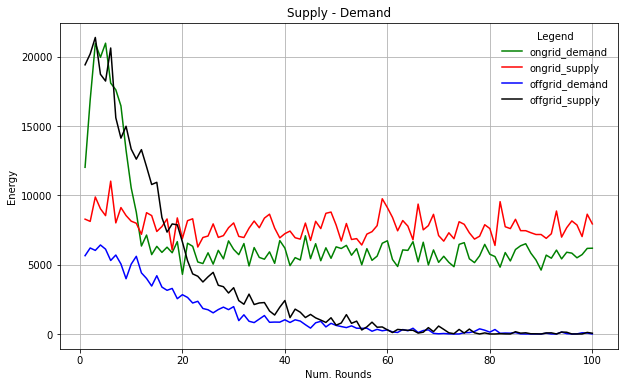

In [ ]:
smart_grid.plot.supply_demand()

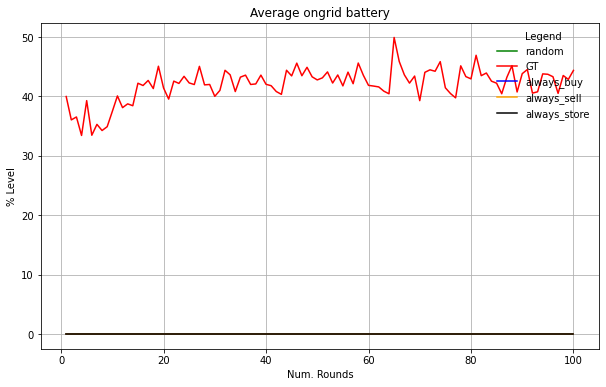

In [ ]:
smart_grid.plot.ongrid_avg_battery()

### 2.2.7 - Simulation with N/5 players ongrid, one for each strategy





#### Smart Grid settings for the simulation

In [ ]:
# Create the smart grid
smart_grid = SmartGrid(rule=RULES[1])

# Add the players
for strategy in STRATEGIES:
  add_players_to_smartgrid(smart_grid, N/5, 'ongrid', strategy)

Added 200 ongrid players with strategy of type random.
Added 200 ongrid players with strategy of type GT.
Added 200 ongrid players with strategy of type always_buy.
Added 200 ongrid players with strategy of type always_sell.
Added 200 ongrid players with strategy of type always_store.


#### Simulation

In [ ]:
# Play the game
play_game(smart_grid, T, verbose=True)

ROUND N.1
START OF THE ROUND
	Players in game: 1000 = ongrid[1000] + offgrid[0]
	Energy supply: 17928.20 = ongrid[17928.20] + offgrid[  0.00]
	Number of suppliers: 225 = ongrid[225] + offgrid[0]
	Energy Demand: 28218.50 = ongrid[28218.50] + offgrid[  0.00]
	Number of demanders: 296 = ongrid[296] + offgrid[0]

END OF THE ROUND
	Players in game: 1000 = ongrid[1000] + offgrid[0]
	Left Energy supply:   0.00 = ongrid[  0.00] + offgrid[  0.00]
	Remaning Number of suppliers: 225 = ongrid[225] + offgrid[0]
	Left Energy Demand: 10290.30 = ongrid[10290.30] + offgrid[  0.00]
	Remaning Number of demanders: 296 = ongrid[296] + offgrid[0]
	Number of excluded players in this round: 0
	Number of excluded player until now: 0

------------------

ROUND N.33
START OF THE ROUND
	Players in game: 579 = ongrid[579] + offgrid[0]
	Energy supply: 11068.78 = ongrid[11068.78] + offgrid[  0.00]
	Number of suppliers: 141 = ongrid[141] + offgrid[0]
	Energy Demand: 8159.28 = ongrid[8159.28] + offgrid[  0.00]
	Number

#### Results

##### GRAPH 1 : average ongrid battery for each strategy

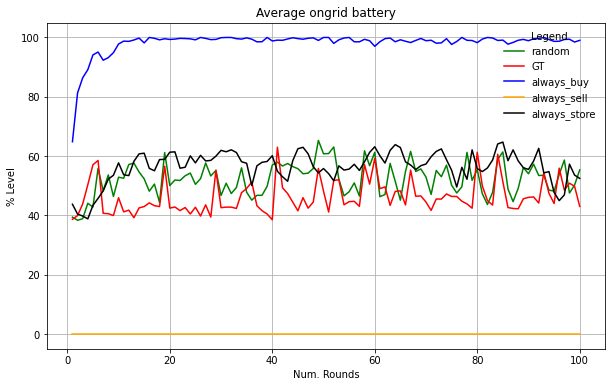

In [ ]:
smart_grid.plot.ongrid_avg_battery()

##### GRAPH 2: average ongrid wallet for each strategy

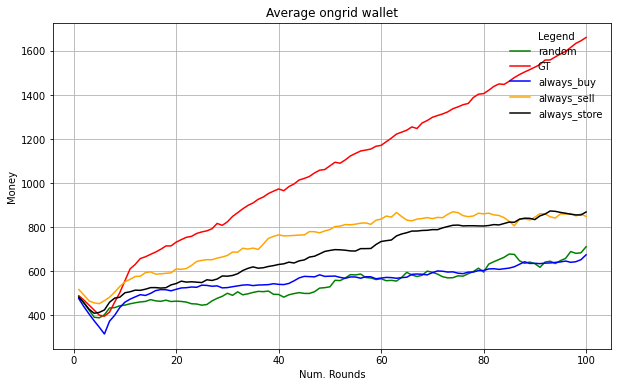

In [ ]:
smart_grid.plot.ongrid_avg_wallet()

##### GRAPH 3: Smart Grid energy supply/demand for each type of player connection (ongrid or offgrid)

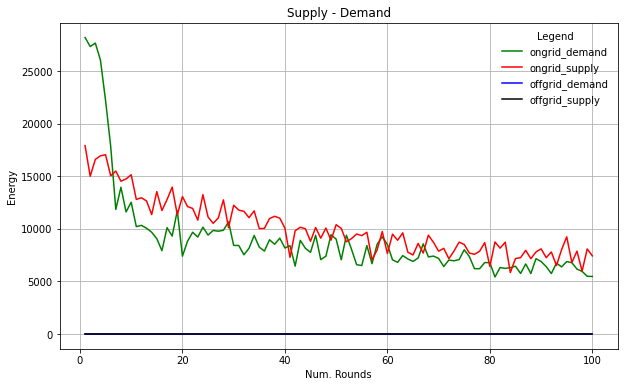

In [ ]:
smart_grid.plot.supply_demand()

### 2.2.8 - Simulation with N/10 players ongrid and N/10 players offgrid, one group for each strategy




#### Smart Grid settings for the simulation

In [ ]:
# Create the smart grid
smart_grid = SmartGrid(rule=RULES[1])

# Add the players
for strategy in STRATEGIES:
  add_players_to_smartgrid(smart_grid, N/10, 'ongrid', strategy)
  add_players_to_smartgrid(smart_grid, N/10, 'offgrid', strategy)

Added 100 ongrid players with strategy of type random.
Added 100 offgrid players with strategy of type random.
Added 100 ongrid players with strategy of type GT.
Added 100 offgrid players with strategy of type GT.
Added 100 ongrid players with strategy of type always_buy.
Added 100 offgrid players with strategy of type always_buy.
Added 100 ongrid players with strategy of type always_sell.
Added 100 offgrid players with strategy of type always_sell.
Added 100 ongrid players with strategy of type always_store.
Added 100 offgrid players with strategy of type always_store.


#### Simulation

In [ ]:
# Play the game
play_game(smart_grid, T, verbose=True)

ROUND N.1
START OF THE ROUND
	Players in game: 1000 = ongrid[500] + offgrid[500]
	Energy supply: 24173.28 = ongrid[8976.91] + offgrid[15196.37]
	Number of suppliers: 268 = ongrid[114] + offgrid[154]
	Energy Demand: 25370.19 = ongrid[14928.12] + offgrid[10442.07]
	Number of demanders: 277 = ongrid[156] + offgrid[121]

END OF THE ROUND
	Players in game: 921 = ongrid[500] + offgrid[421]
	Left Energy supply:   0.00 = ongrid[  0.00] + offgrid[  0.00]
	Remaning Number of suppliers: 268 = ongrid[114] + offgrid[154]
	Left Energy Demand: 1196.91 = ongrid[615.05] + offgrid[581.86]
	Remaning Number of demanders: 277 = ongrid[156] + offgrid[121]
	Number of excluded players in this round: 79
	Number of excluded player until now: 79

------------------

ROUND N.33
START OF THE ROUND
	Players in game: 338 = ongrid[288] + offgrid[50]
	Energy supply: 5317.53 = ongrid[4812.97] + offgrid[504.55]
	Number of suppliers: 71 = ongrid[65] + offgrid[6]
	Energy Demand: 5030.74 = ongrid[4223.07] + offgrid[807.67]

#### Results

##### GRAPH 1 : average ongrid battery for each strategy

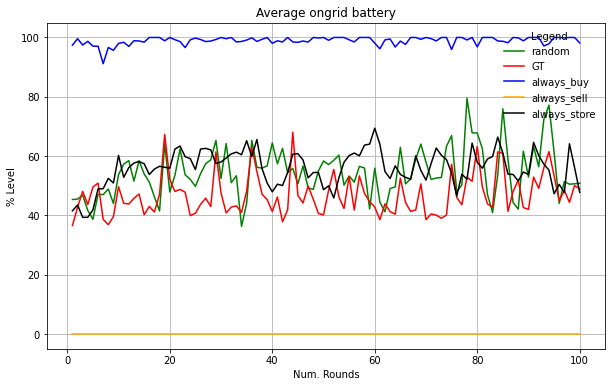

In [ ]:
smart_grid.plot.ongrid_avg_battery()

##### GRAPH 2: average offgrid battery for each strategy

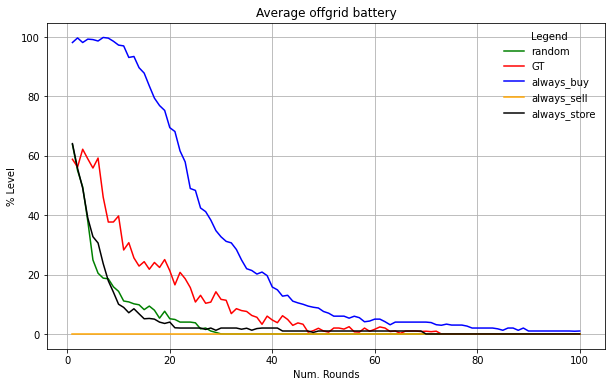

In [ ]:
smart_grid.plot.offgrid_avg_battery()

##### GRAPH 3: average ongrid wallet for each strategy

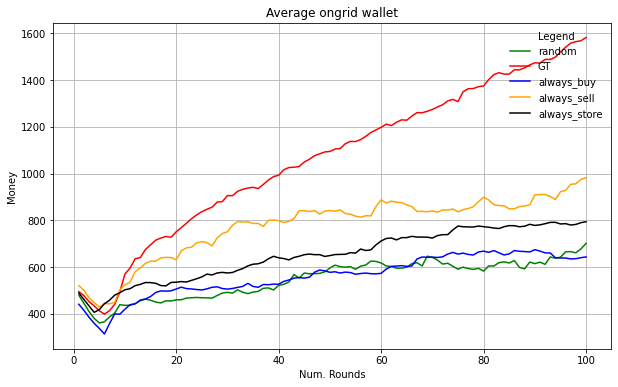

In [ ]:
smart_grid.plot.ongrid_avg_wallet()

##### GRAPH 4: average offgrid wallet for each strategy

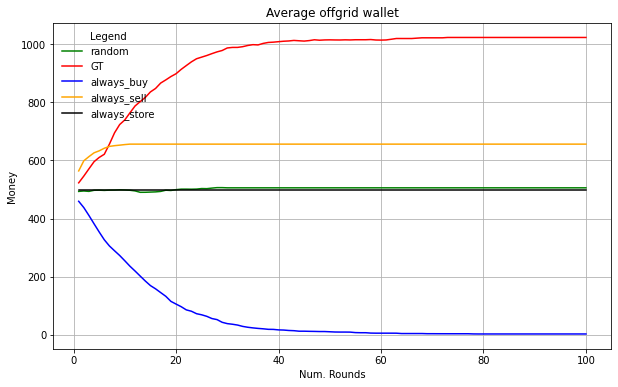

In [ ]:
smart_grid.plot.offgrid_avg_wallet()

##### GRAPH 5: Smart Grid energy supply/demand for each type of player connection (ongrid or offgrid)

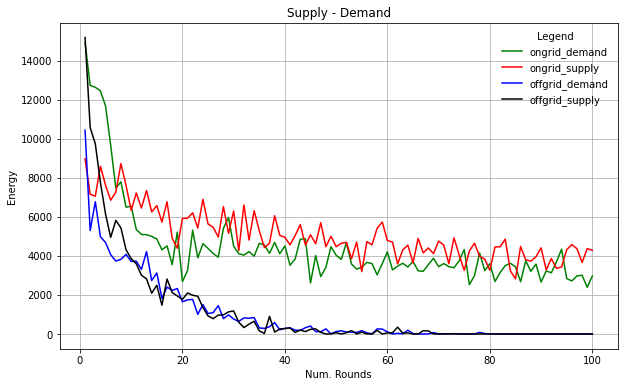

In [ ]:
smart_grid.plot.supply_demand()

## 2.3 - SIMULATION WITH MIXED RULE

* Offgrid players are always served before the ongrid players.

* Offgrid players are served with a priority queue rule.

* Ongrid players are served with a energy splitting rule.

### 2.3.1 - Simulation with 1 player ongrid and 1 offgrid, both with GT strategy

#### Smart Grid settings for the simulation

In [ ]:
# Create the smart grid
smart_grid = SmartGrid(rule=RULES[2])

# Add players
add_players_to_smartgrid(smart_grid, 1, 'ongrid', STRATEGIES[1])
add_players_to_smartgrid(smart_grid, 1, 'offgrid', STRATEGIES[1])

Added 1 ongrid players with strategy of type GT.
Added 1 offgrid players with strategy of type GT.


#### Simulation

In [ ]:
# Play the game
play_game(smart_grid, T, verbose=True)

ROUND N.1
START OF THE ROUND
	Players in game: 2 = ongrid[1] + offgrid[1]
	Energy supply: 277.25 = ongrid[  0.00] + offgrid[277.25]
	Number of suppliers: 1 = ongrid[0] + offgrid[1]
	Energy Demand:   0.00 = ongrid[  0.00] + offgrid[  0.00]
	Number of demanders: 0 = ongrid[0] + offgrid[0]

END OF THE ROUND
	Players in game: 2 = ongrid[1] + offgrid[1]
	Left Energy supply: 277.25 = ongrid[  0.00] + offgrid[277.25]
	Remaning Number of suppliers: 1 = ongrid[0] + offgrid[1]
	Left Energy Demand:   0.00 = ongrid[  0.00] + offgrid[  0.00]
	Remaning Number of demanders: 0 = ongrid[0] + offgrid[0]
	Number of excluded players in this round: 0
	Number of excluded player until now: 0

------------------

ROUND N.33
START OF THE ROUND
	Players in game: 0 = ongrid[0] + offgrid[0]
	Energy supply:   0.00 = ongrid[  0.00] + offgrid[  0.00]
	Number of suppliers: 0 = ongrid[0] + offgrid[0]
	Energy Demand:   0.00 = ongrid[  0.00] + offgrid[  0.00]
	Number of demanders: 0 = ongrid[0] + offgrid[0]

END OF THE 

#### Results

##### GRAPH 1 : average ongrid battery for each strategy

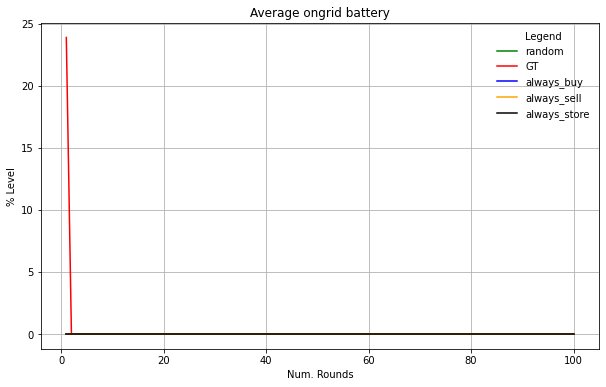

In [ ]:
smart_grid.plot.ongrid_avg_battery()

##### GRAPH 2: average offgrid battery for each strategy

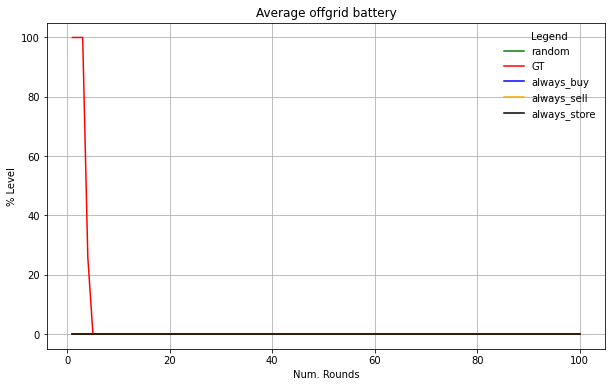

In [ ]:
smart_grid.plot.offgrid_avg_battery()

##### GRAPH 3: average ongrid wallet for each strategy

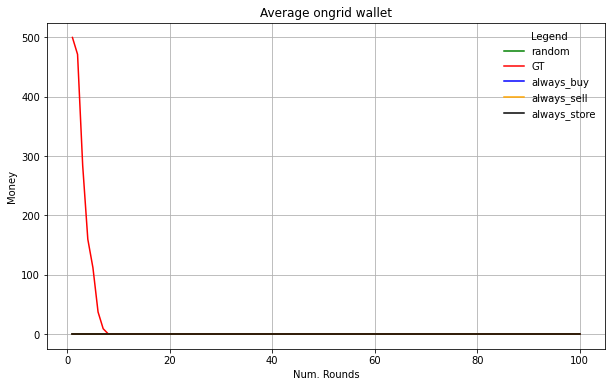

In [ ]:
smart_grid.plot.ongrid_avg_wallet()

##### GRAPH 4: average offgrid wallet for each strategy

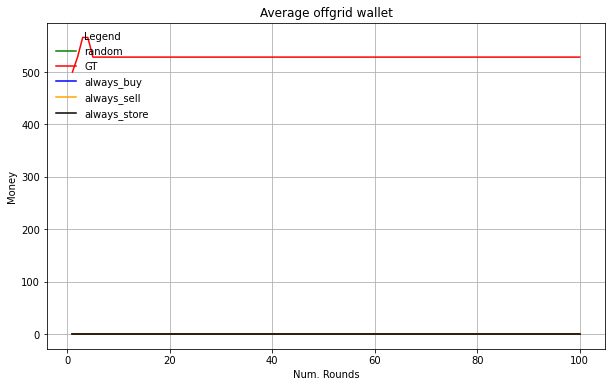

In [ ]:
smart_grid.plot.offgrid_avg_wallet()

##### GRAPH 5: Smart Grid energy supply/demand for each type of player connection (ongrid or offgrid)

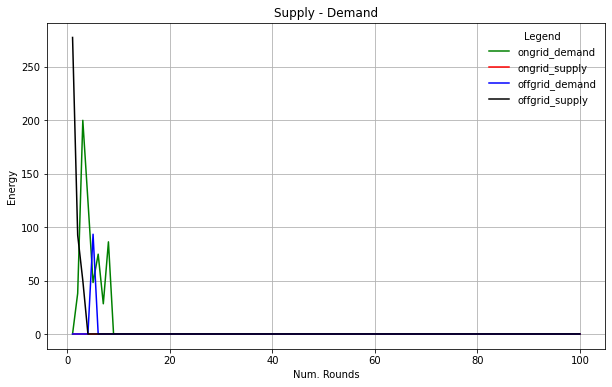

In [ ]:
smart_grid.plot.supply_demand()

### 2.3.2 - Simulation with 5 players ongrid and 5 players offgrid, one for each strategy




#### Smart Grid settings for the simulation

In [ ]:
# Create the smart grid
smart_grid = SmartGrid(rule=RULES[2])

# Add the players
for strategy in STRATEGIES:
  add_players_to_smartgrid(smart_grid, 1, 'ongrid', strategy)
  add_players_to_smartgrid(smart_grid, 1, 'offgrid', strategy)

Added 1 ongrid players with strategy of type random.
Added 1 offgrid players with strategy of type random.
Added 1 ongrid players with strategy of type GT.
Added 1 offgrid players with strategy of type GT.
Added 1 ongrid players with strategy of type always_buy.
Added 1 offgrid players with strategy of type always_buy.
Added 1 ongrid players with strategy of type always_sell.
Added 1 offgrid players with strategy of type always_sell.
Added 1 ongrid players with strategy of type always_store.
Added 1 offgrid players with strategy of type always_store.


#### Simulation

In [ ]:
# Play the game
play_game(smart_grid, T, verbose=True)

ROUND N.1
START OF THE ROUND
	Players in game: 10 = ongrid[5] + offgrid[5]
	Energy supply:  51.65 = ongrid[ 42.25] + offgrid[  9.40]
	Number of suppliers: 2 = ongrid[1] + offgrid[1]
	Energy Demand:  67.62 = ongrid[ 64.81] + offgrid[  2.81]
	Number of demanders: 2 = ongrid[1] + offgrid[1]

END OF THE ROUND
	Players in game: 9 = ongrid[5] + offgrid[4]
	Left Energy supply:   0.00 = ongrid[  0.00] + offgrid[  0.00]
	Remaning Number of suppliers: 2 = ongrid[1] + offgrid[1]
	Left Energy Demand:  13.16 = ongrid[ 13.16] + offgrid[  0.00]
	Remaning Number of demanders: 2 = ongrid[1] + offgrid[1]
	Number of excluded players in this round: 1
	Number of excluded player until now: 1

------------------

ROUND N.33
START OF THE ROUND
	Players in game: 3 = ongrid[3] + offgrid[0]
	Energy supply:   0.00 = ongrid[  0.00] + offgrid[  0.00]
	Number of suppliers: 0 = ongrid[0] + offgrid[0]
	Energy Demand:  96.26 = ongrid[ 96.26] + offgrid[  0.00]
	Number of demanders: 2 = ongrid[2] + offgrid[0]

END OF THE

#### Results

##### GRAPH 1 : average ongrid battery for each strategy

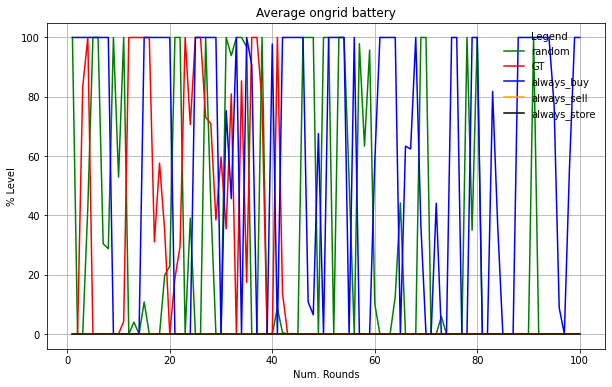

In [ ]:
smart_grid.plot.ongrid_avg_battery()

##### GRAPH 2: average offgrid battery for each strategy

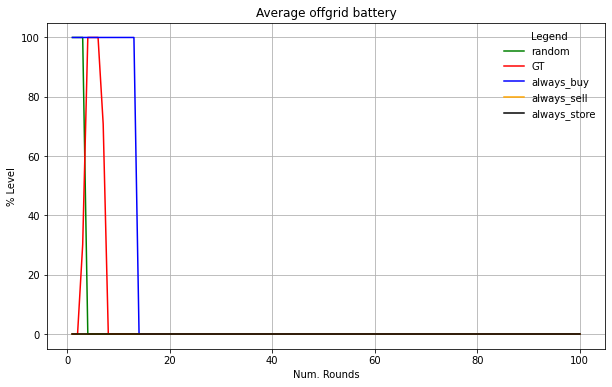

In [ ]:
smart_grid.plot.offgrid_avg_battery()

##### GRAPH 3: average ongrid wallet for each strategy

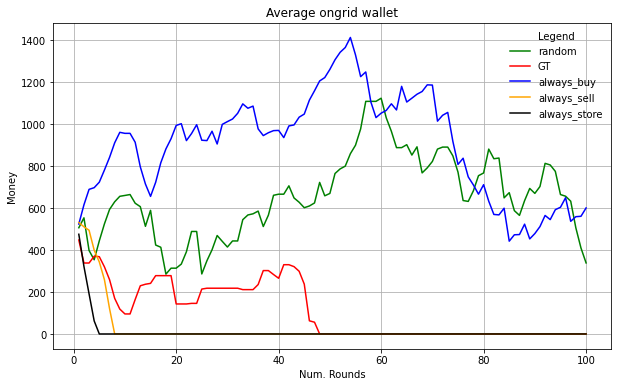

In [ ]:
smart_grid.plot.ongrid_avg_wallet()

##### GRAPH 4: average offgrid wallet for each strategy

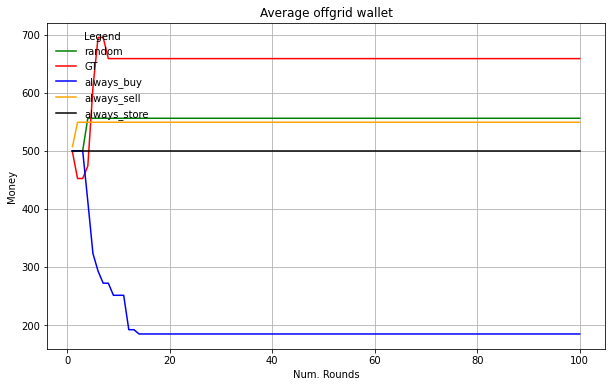

In [ ]:
smart_grid.plot.offgrid_avg_wallet()

##### GRAPH 5: Smart Grid energy supply/demand for each type of player connection (ongrid or offgrid)

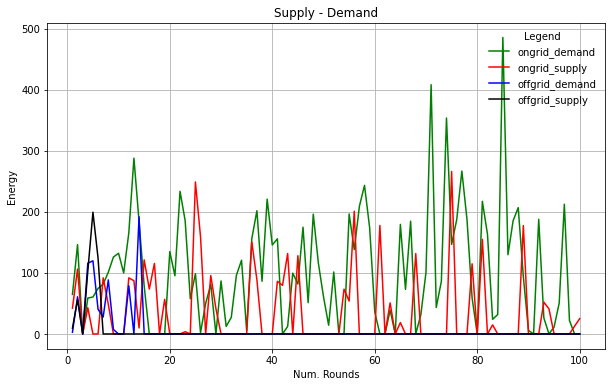

In [ ]:
smart_grid.plot.supply_demand()

### 2.3.3 - Simulation with N/2 player ongrid and N/2 offgrid, both with GT strategy

#### Smart Grid settings for the simulation

In [ ]:
# Create the smart grid
smart_grid = SmartGrid(rule=RULES[1])

# Add players
add_players_to_smartgrid(smart_grid, N/2, 'ongrid', STRATEGIES[1])
add_players_to_smartgrid(smart_grid, N/2, 'offgrid', STRATEGIES[1])

Added 500 ongrid players with strategy of type GT.
Added 500 offgrid players with strategy of type GT.


#### Simulation

In [ ]:
# Play the game
play_game(smart_grid, T, verbose=True)

ROUND N.1
START OF THE ROUND
	Players in game: 1000 = ongrid[500] + offgrid[500]
	Energy supply: 26805.05 = ongrid[7978.72] + offgrid[18826.33]
	Number of suppliers: 305 = ongrid[103] + offgrid[202]
	Energy Demand: 17959.69 = ongrid[12385.07] + offgrid[5574.62]
	Number of demanders: 285 = ongrid[187] + offgrid[98]

END OF THE ROUND
	Players in game: 995 = ongrid[500] + offgrid[495]
	Left Energy supply: 8845.36 = ongrid[2969.12] + offgrid[5876.24]
	Remaning Number of suppliers: 305 = ongrid[103] + offgrid[202]
	Left Energy Demand:   0.00 = ongrid[  0.00] + offgrid[ -0.00]
	Remaning Number of demanders: 285 = ongrid[187] + offgrid[98]
	Number of excluded players in this round: 5
	Number of excluded player until now: 5

------------------

ROUND N.33
START OF THE ROUND
	Players in game: 391 = ongrid[306] + offgrid[85]
	Energy supply: 9866.66 = ongrid[7345.95] + offgrid[2520.71]
	Number of suppliers: 128 = ongrid[102] + offgrid[26]
	Energy Demand: 6433.79 = ongrid[4832.75] + offgrid[1601.0

#### Results

##### GRAPH 1 : average ongrid battery for each strategy

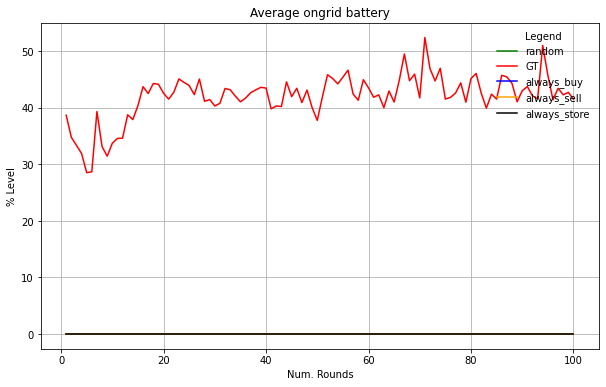

In [ ]:
smart_grid.plot.ongrid_avg_battery()

##### GRAPH 2: average offgrid battery for each strategy

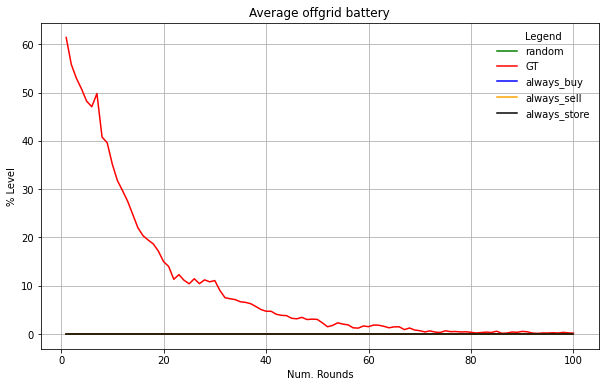

In [ ]:
smart_grid.plot.offgrid_avg_battery()

##### GRAPH 3: average ongrid wallet for each strategy

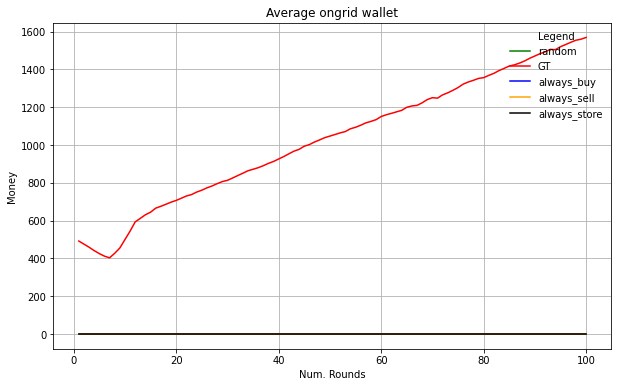

In [ ]:
smart_grid.plot.ongrid_avg_wallet()

##### GRAPH 4: average offgrid wallet for each strategy

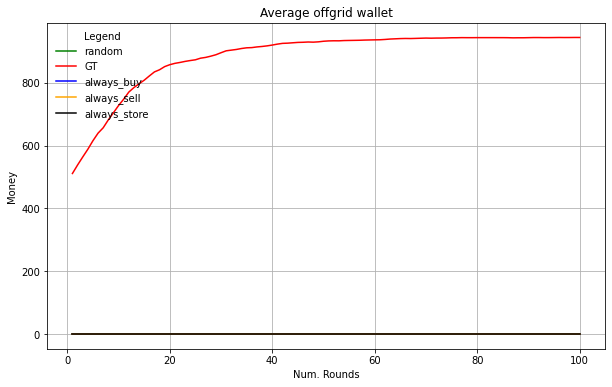

In [ ]:
smart_grid.plot.offgrid_avg_wallet()

##### GRAPH 5: Smart Grid energy supply/demand for each type of player connection (ongrid or offgrid)

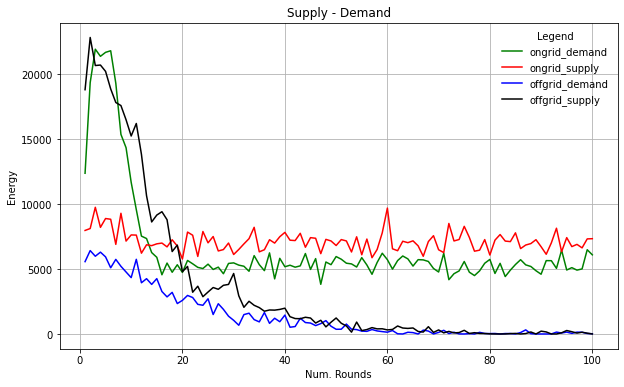

In [ ]:
smart_grid.plot.supply_demand()

### 2.3.4 - Simulation with N/10 players ongrid and N/10 players offgrid, one group for each strategy




#### Smart Grid settings for the simulation

In [ ]:
# Create the smart grid
smart_grid = SmartGrid(rule=RULES[2])

# Add the players
for strategy in STRATEGIES:
  add_players_to_smartgrid(smart_grid, N/10, 'ongrid', strategy)
  add_players_to_smartgrid(smart_grid, N/10, 'offgrid', strategy)

Added 100 ongrid players with strategy of type random.
Added 100 offgrid players with strategy of type random.
Added 100 ongrid players with strategy of type GT.
Added 100 offgrid players with strategy of type GT.
Added 100 ongrid players with strategy of type always_buy.
Added 100 offgrid players with strategy of type always_buy.
Added 100 ongrid players with strategy of type always_sell.
Added 100 offgrid players with strategy of type always_sell.
Added 100 ongrid players with strategy of type always_store.
Added 100 offgrid players with strategy of type always_store.


#### Simulation

In [ ]:
# Play the game
play_game(smart_grid, T, verbose=True)

ROUND N.1
START OF THE ROUND
	Players in game: 1000 = ongrid[500] + offgrid[500]
	Energy supply: 25140.85 = ongrid[9377.54] + offgrid[15763.32]
	Number of suppliers: 268 = ongrid[114] + offgrid[154]
	Energy Demand: 24928.71 = ongrid[14482.69] + offgrid[10446.02]
	Number of demanders: 279 = ongrid[151] + offgrid[128]

END OF THE ROUND
	Players in game: 928 = ongrid[500] + offgrid[428]
	Left Energy supply:   0.00 = ongrid[  0.00] + offgrid[  0.00]
	Remaning Number of suppliers: 268 = ongrid[114] + offgrid[154]
	Left Energy Demand:  -0.00 = ongrid[ -0.00] + offgrid[  0.00]
	Remaning Number of demanders: 279 = ongrid[151] + offgrid[128]
	Number of excluded players in this round: 72
	Number of excluded player until now: 72

------------------

ROUND N.33
START OF THE ROUND
	Players in game: 386 = ongrid[297] + offgrid[89]
	Energy supply: 8262.41 = ongrid[5383.07] + offgrid[2879.34]
	Number of suppliers: 95 = ongrid[68] + offgrid[27]
	Energy Demand: 3828.49 = ongrid[3400.98] + offgrid[427.52

#### Results

##### GRAPH 1 : average ongrid battery for each strategy

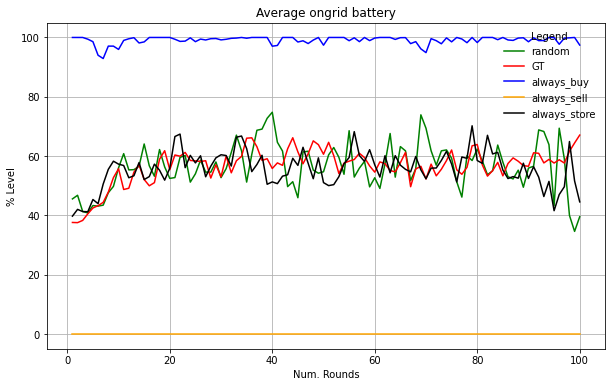

In [ ]:
smart_grid.plot.ongrid_avg_battery()

##### GRAPH 2: average offgrid battery for each strategy

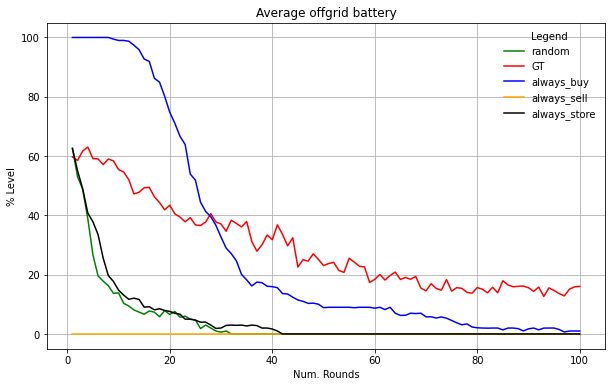

In [ ]:
smart_grid.plot.offgrid_avg_battery()

##### GRAPH 3: average ongrid wallet for each strategy

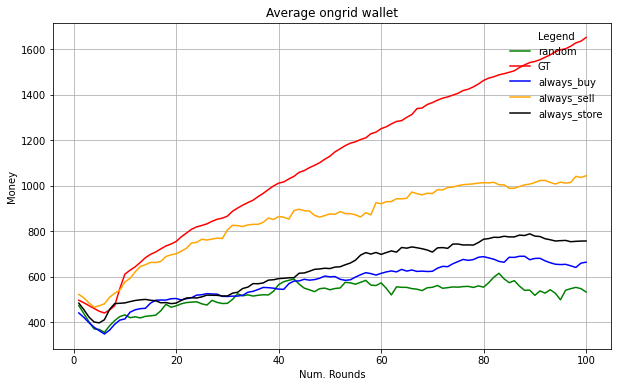

In [ ]:
smart_grid.plot.ongrid_avg_wallet()

##### GRAPH 4: average offgrid wallet for each strategy

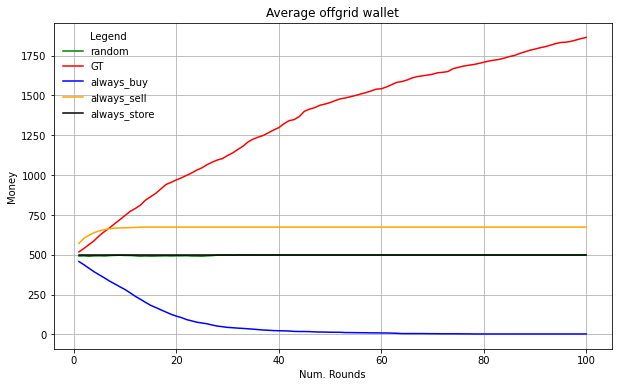

In [ ]:
smart_grid.plot.offgrid_avg_wallet()

##### GRAPH 5: Smart Grid energy supply/demand for each type of player connection (ongrid or offgrid)

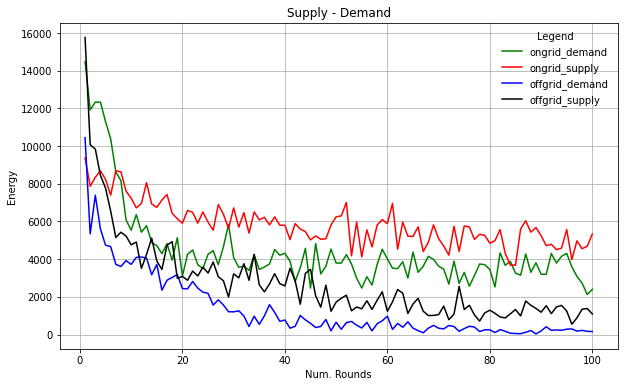

In [ ]:
smart_grid.plot.supply_demand()